# Steam Review Analysis

**Introduction to Steam Review Analysis Project**

**Objective:**
The Steam Review Analysis project aims to explore and derive insights from a large dataset containing reviews of games on the Steam platform. Leveraging PySpark for data processing, Pandas for exploratory data analysis (EDA), and visualization libraries like Matplotlib and Seaborn, the project focuses on several key categories to uncover patterns, trends, and valuable information from the vast amount of Steam review data.

**Data Source:**
The dataset, sourced from Kaggle ([Steam Reviews 2021](https://www.kaggle.com/datasets/najzeko/steam-reviews-2021)), comprises approximately 8 GB of data with 17 million rows and 23 columns. The dataset provides detailed information about individual game reviews, including attributes such as the review text, author details, game information, and more.

**Project Components:**

1. **Games Analysis:**
   - Explore the distribution of reviews among different games.
   - Identify the most reviewed and highest-rated games.
   - Analyze the trends in game reviews over time.

2. **Language Analysis:**
   - Examine the distribution of reviews across different languages.
   - Explore the sentiment of reviews in different languages.
   - Identify popular languages among Steam users.

3. **Time Analysis:**
   - Investigate how the volume of reviews changes over time.
   - Analyze temporal patterns in sentiment.
   - Identify peak times for reviews.

4. **Author Analysis:**
   - Explore characteristics of authors, such as the number of games owned and reviewed.
   - Identify prolific reviewers and their reviewing behavior.
   - Analyze playtime patterns of reviewers.

5. **Game Recommendation using ALS model:**
   - Alternating Least Squares matrix factorization model is implemented to recommend games to players who plays a game.
   - It is a popular collaborative filtering algorithm.
   - The model is trained using the author indices, app indices, and ratings.
   - We use the trained model to generate recommendations for all gamers.

**Technology Stack:**
- **Spark SQL:** Used for extraction, processing, and analysis of the data set.
- **Spark MLib:** Uses the ALS collaborative filtering algorithm for recommending games.
- **Pandas:** Employed for exploratory data analysis and manipulation.
- **Matplotlib and Seaborn:** Utilized for data visualization to derive meaningful insights.
- **Hadoop Distributed File System (HDFS):** Chosen for storing the extensive dataset.

**References:**
The project drew inspiration and guidance from existing Kaggle kernels, particularly [Steam Reviews](https://www.kaggle.com/code/gonzafrancoandres/steam-reviews) and [Review Analysis by PySpark](https://www.kaggle.com/code/iplori/review-analysis-by-pyspark), for building upon best practices in working with Steam review data.

Through comprehensive analysis across these categories, the Steam Review Analysis project seeks to provide valuable insights for game developers, platform administrators, and researchers interested in understanding user sentiments and behaviors within the Steam gaming community.

## Import Libraries

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.functions import from_unixtime
from pyspark.ml.recommendation import ALS
from pyspark.ml.feature import StringIndexer, IndexToString
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats

## Data Extraction from HDFS with PySpark

In [2]:
spark = SparkSession.builder.appName("SteamReviewAnalysis").master("yarn").getOrCreate()

23/12/12 14:28:10 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [3]:
data = "hdfs://localhost:9000/user/steam_analysis/steam_reviews.csv"

### Data Extraction

In [4]:
data_csv = spark.read.csv(data, inferSchema = True, header = True)

In [5]:
data_csv.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- app_id: string (nullable = true)
 |-- app_name: string (nullable = true)
 |-- review_id: string (nullable = true)
 |-- language: string (nullable = true)
 |-- review: string (nullable = true)
 |-- timestamp_created: string (nullable = true)
 |-- timestamp_updated: string (nullable = true)
 |-- recommended: string (nullable = true)
 |-- votes_helpful: string (nullable = true)
 |-- votes_funny: string (nullable = true)
 |-- weighted_vote_score: string (nullable = true)
 |-- comment_count: string (nullable = true)
 |-- steam_purchase: string (nullable = true)
 |-- received_for_free: string (nullable = true)
 |-- written_during_early_access: string (nullable = true)
 |-- author.steamid: string (nullable = true)
 |-- author.num_games_owned: string (nullable = true)
 |-- author.num_reviews: string (nullable = true)
 |-- author.playtime_forever: string (nullable = true)
 |-- author.playtime_last_two_weeks: string (nullable = true)
 |-- author.playt

In [6]:
data_csv.count()

40848659

## Data Cleaning and Pre-Processing

- Convert the column names into valid names - remove the dots and replace them with underscore.
- Remove the NULL records from the data set 
- Convert the columns into appropriate data types. For e.g., app_id can be converted to IntegerType() and all the timestamp strings into timestamps.

In [7]:
# changes the column names to abide the standard nomenclature
data_csv = data_csv.withColumnRenamed("author.steamid","author_steamid"). \
withColumnRenamed("author.num_games_owned","author_num_games_owned").\
withColumnRenamed("author.num_reviews", "author_num_reviews").\
withColumnRenamed("author.playtime_forever","author_playtime_forever").\
withColumnRenamed("author.playtime_at_review","author_playtime_at_review").\
withColumnRenamed("author.last_played","author_last_played").\
withColumnRenamed("author.playtime_last_two_weeks", "author_playtime_last_two_weeks")

In [8]:
data_csv.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- app_id: string (nullable = true)
 |-- app_name: string (nullable = true)
 |-- review_id: string (nullable = true)
 |-- language: string (nullable = true)
 |-- review: string (nullable = true)
 |-- timestamp_created: string (nullable = true)
 |-- timestamp_updated: string (nullable = true)
 |-- recommended: string (nullable = true)
 |-- votes_helpful: string (nullable = true)
 |-- votes_funny: string (nullable = true)
 |-- weighted_vote_score: string (nullable = true)
 |-- comment_count: string (nullable = true)
 |-- steam_purchase: string (nullable = true)
 |-- received_for_free: string (nullable = true)
 |-- written_during_early_access: string (nullable = true)
 |-- author_steamid: string (nullable = true)
 |-- author_num_games_owned: string (nullable = true)
 |-- author_num_reviews: string (nullable = true)
 |-- author_playtime_forever: string (nullable = true)
 |-- author_playtime_last_two_weeks: string (nullable = true)
 |-- author_playt

In [9]:
data = data_csv.drop("review")

In [10]:
data.show()

+---------------------------+----------+--------------------+---------+--------+-----------------+-----------------+-----------+-------------+-----------+-------------------+-------------+--------------+-----------------+---------------------------+-----------------+----------------------+------------------+-----------------------+------------------------------+-------------------------+------------------+
|                        _c0|    app_id|            app_name|review_id|language|timestamp_created|timestamp_updated|recommended|votes_helpful|votes_funny|weighted_vote_score|comment_count|steam_purchase|received_for_free|written_during_early_access|   author_steamid|author_num_games_owned|author_num_reviews|author_playtime_forever|author_playtime_last_two_weeks|author_playtime_at_review|author_last_played|
+---------------------------+----------+--------------------+---------+--------+-----------------+-----------------+-----------+-------------+-----------+-------------------+------

23/12/12 14:28:40 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , app_id, app_name, review_id, language, timestamp_created, timestamp_updated, recommended, votes_helpful, votes_funny, weighted_vote_score, comment_count, steam_purchase, received_for_free, written_during_early_access, author.steamid, author.num_games_owned, author.num_reviews, author.playtime_forever, author.playtime_last_two_weeks, author.playtime_at_review, author.last_played
 Schema: _c0, app_id, app_name, review_id, language, timestamp_created, timestamp_updated, recommended, votes_helpful, votes_funny, weighted_vote_score, comment_count, steam_purchase, received_for_free, written_during_early_access, author.steamid, author.num_games_owned, author.num_reviews, author.playtime_forever, author.playtime_last_two_weeks, author.playtime_at_review, author.last_played
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/user/steam_analysis/steam_reviews.csv


### Data Cleaning

In [11]:
#Drops all the records with NULL values
data = data.na.drop(how = "any")

In [12]:
data.count()

23/12/12 14:28:40 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , app_id, app_name, review_id, language, timestamp_created, timestamp_updated, recommended, votes_helpful, votes_funny, weighted_vote_score, comment_count, steam_purchase, received_for_free, written_during_early_access, author.steamid, author.num_games_owned, author.num_reviews, author.playtime_forever, author.playtime_last_two_weeks, author.playtime_at_review, author.last_played
 Schema: _c0, app_id, app_name, review_id, language, timestamp_created, timestamp_updated, recommended, votes_helpful, votes_funny, weighted_vote_score, comment_count, steam_purchase, received_for_free, written_during_early_access, author.steamid, author.num_games_owned, author.num_reviews, author.playtime_forever, author.playtime_last_two_weeks, author.playtime_at_review, author.last_played
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/user/steam_analysis/steam_reviews.csv


16876852

In [13]:
data.show()

+---+------+--------------------+---------+--------+-----------------+-----------------+-----------+-------------+-----------+-------------------+-------------+--------------+-----------------+---------------------------+-----------------+----------------------+------------------+-----------------------+------------------------------+-------------------------+------------------+
|_c0|app_id|            app_name|review_id|language|timestamp_created|timestamp_updated|recommended|votes_helpful|votes_funny|weighted_vote_score|comment_count|steam_purchase|received_for_free|written_during_early_access|   author_steamid|author_num_games_owned|author_num_reviews|author_playtime_forever|author_playtime_last_two_weeks|author_playtime_at_review|author_last_played|
+---+------+--------------------+---------+--------+-----------------+-----------------+-----------+-------------+-----------+-------------------+-------------+--------------+-----------------+---------------------------+---------------

23/12/12 14:29:04 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , app_id, app_name, review_id, language, timestamp_created, timestamp_updated, recommended, votes_helpful, votes_funny, weighted_vote_score, comment_count, steam_purchase, received_for_free, written_during_early_access, author.steamid, author.num_games_owned, author.num_reviews, author.playtime_forever, author.playtime_last_two_weeks, author.playtime_at_review, author.last_played
 Schema: _c0, app_id, app_name, review_id, language, timestamp_created, timestamp_updated, recommended, votes_helpful, votes_funny, weighted_vote_score, comment_count, steam_purchase, received_for_free, written_during_early_access, author.steamid, author.num_games_owned, author.num_reviews, author.playtime_forever, author.playtime_last_two_weeks, author.playtime_at_review, author.last_played
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/user/steam_analysis/steam_reviews.csv


### Data Pre-processing

In [14]:
# Changing the data type of each columns into appropriate types
data = data.withColumn("app_id",data["app_id"].cast(IntegerType())).\
            withColumn("author_steamid", data["author_steamid"].cast(LongType())).\
            withColumn("recommended", data["recommended"].cast(BooleanType())).\
            withColumn("steam_purchase", data["steam_purchase"].cast(BooleanType())).\
            withColumn("author_num_games_owned", data["author_num_games_owned"].cast(IntegerType())).\
            withColumn("author_num_reviews", data["author_num_reviews"].cast(IntegerType())).\
            withColumn("author_playtime_forever", data["author_playtime_forever"].cast(FloatType())).\
            withColumn("author_playtime_at_review", data["author_playtime_at_review"].cast(FloatType()))

In [15]:
# Converting the time columns into timestamp data type
data = data.withColumn("timestamp_created", from_unixtime("timestamp_created").cast("timestamp")).\
            withColumn("author_last_played", from_unixtime(data["author_last_played"]).cast(TimestampType())).\
            withColumn("timestamp_updated", from_unixtime(data["timestamp_updated"]).cast(TimestampType()))

In [16]:
data.printSchema() #after proper type casting

root
 |-- _c0: string (nullable = true)
 |-- app_id: integer (nullable = true)
 |-- app_name: string (nullable = true)
 |-- review_id: string (nullable = true)
 |-- language: string (nullable = true)
 |-- timestamp_created: timestamp (nullable = true)
 |-- timestamp_updated: timestamp (nullable = true)
 |-- recommended: boolean (nullable = true)
 |-- votes_helpful: string (nullable = true)
 |-- votes_funny: string (nullable = true)
 |-- weighted_vote_score: string (nullable = true)
 |-- comment_count: string (nullable = true)
 |-- steam_purchase: boolean (nullable = true)
 |-- received_for_free: string (nullable = true)
 |-- written_during_early_access: string (nullable = true)
 |-- author_steamid: long (nullable = true)
 |-- author_num_games_owned: integer (nullable = true)
 |-- author_num_reviews: integer (nullable = true)
 |-- author_playtime_forever: float (nullable = true)
 |-- author_playtime_last_two_weeks: string (nullable = true)
 |-- author_playtime_at_review: float (nullable

### Data Pre-processing

In [17]:
# We form a list of columns to be included in different smaller data frames
col_demo = ["app_id", "app_name", "review_id", "language", "author_steamid", "timestamp_created" ,"author_playtime_forever","recommended"]
col_author = ["steam_purchase", 'author_steamid', "author_num_games_owned", "author_num_reviews", "author_playtime_forever", "author_playtime_at_review", "author_last_played","recommended"]
col_time = [ "app_id", "app_name", "timestamp_created", "timestamp_updated", 'author_playtime_at_review', "recommended"]
col_rev = [ "app_id", "app_name", "language", "recommended"]
col_rec = ["app_id", "app_name", "recommended"] # checking recommendation % for a specific game

In [18]:
data_demo = data.select(*col_demo)

In [19]:
data_demo.show()

+------+--------------------+---------+--------+-----------------+-------------------+-----------------------+-----------+
|app_id|            app_name|review_id|language|   author_steamid|  timestamp_created|author_playtime_forever|recommended|
+------+--------------------+---------+--------+-----------------+-------------------+-----------------------+-----------+
|292030|The Witcher 3: Wi...| 85185598|schinese|76561199095369542|2021-01-23 01:00:29|                 1909.0|       true|
|292030|The Witcher 3: Wi...| 85185250|schinese|76561198949504115|2021-01-23 00:50:30|                 2764.0|       true|
|292030|The Witcher 3: Wi...| 85185111|schinese|76561199090098988|2021-01-23 00:46:40|                 1061.0|       true|
|292030|The Witcher 3: Wi...| 85184605| english|76561199054755373|2021-01-23 00:32:50|                 5587.0|       true|
|292030|The Witcher 3: Wi...| 85184287|schinese|76561199028326951|2021-01-23 00:23:47|                  217.0|       true|
|292030|The Witc

23/12/12 14:29:04 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , app_id, app_name, review_id, language, timestamp_created, timestamp_updated, recommended, votes_helpful, votes_funny, weighted_vote_score, comment_count, steam_purchase, received_for_free, written_during_early_access, author.steamid, author.num_games_owned, author.num_reviews, author.playtime_forever, author.playtime_last_two_weeks, author.playtime_at_review, author.last_played
 Schema: _c0, app_id, app_name, review_id, language, timestamp_created, timestamp_updated, recommended, votes_helpful, votes_funny, weighted_vote_score, comment_count, steam_purchase, received_for_free, written_during_early_access, author.steamid, author.num_games_owned, author.num_reviews, author.playtime_forever, author.playtime_last_two_weeks, author.playtime_at_review, author.last_played
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/user/steam_analysis/steam_reviews.csv


In [20]:
data_author = data.select(*col_author)
data_author.show()

+--------------+-----------------+----------------------+------------------+-----------------------+-------------------------+-------------------+-----------+
|steam_purchase|   author_steamid|author_num_games_owned|author_num_reviews|author_playtime_forever|author_playtime_at_review| author_last_played|recommended|
+--------------+-----------------+----------------------+------------------+-----------------------+-------------------------+-------------------+-----------+
|          true|76561199095369542|                     6|                 2|                 1909.0|                   1909.0|2021-01-22 14:23:03|       true|
|          true|76561198949504115|                    30|                10|                 2764.0|                   2674.0|2021-01-23 02:18:27|       true|
|          true|76561199090098988|                     5|                 1|                 1061.0|                   1060.0|2021-01-23 01:36:17|       true|
|          true|76561199054755373|            

23/12/12 14:29:04 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , app_id, app_name, review_id, language, timestamp_created, timestamp_updated, recommended, votes_helpful, votes_funny, weighted_vote_score, comment_count, steam_purchase, received_for_free, written_during_early_access, author.steamid, author.num_games_owned, author.num_reviews, author.playtime_forever, author.playtime_last_two_weeks, author.playtime_at_review, author.last_played
 Schema: _c0, app_id, app_name, review_id, language, timestamp_created, timestamp_updated, recommended, votes_helpful, votes_funny, weighted_vote_score, comment_count, steam_purchase, received_for_free, written_during_early_access, author.steamid, author.num_games_owned, author.num_reviews, author.playtime_forever, author.playtime_last_two_weeks, author.playtime_at_review, author.last_played
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/user/steam_analysis/steam_reviews.csv


In [21]:
data_time = data.select(*col_time)
data_time.show()

+------+--------------------+-------------------+-------------------+-------------------------+-----------+
|app_id|            app_name|  timestamp_created|  timestamp_updated|author_playtime_at_review|recommended|
+------+--------------------+-------------------+-------------------+-------------------------+-----------+
|292030|The Witcher 3: Wi...|2021-01-23 01:00:29|2021-01-23 01:00:29|                   1909.0|       true|
|292030|The Witcher 3: Wi...|2021-01-23 00:50:30|2021-01-23 00:50:30|                   2674.0|       true|
|292030|The Witcher 3: Wi...|2021-01-23 00:46:40|2021-01-23 00:46:40|                   1060.0|       true|
|292030|The Witcher 3: Wi...|2021-01-23 00:32:50|2021-01-23 00:32:50|                   5524.0|       true|
|292030|The Witcher 3: Wi...|2021-01-23 00:23:47|2021-01-23 00:23:47|                    217.0|       true|
|292030|The Witcher 3: Wi...|2021-01-23 00:21:04|2021-01-23 00:21:04|                    823.0|       true|
|292030|The Witcher 3: Wi...

23/12/12 14:29:04 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , app_id, app_name, review_id, language, timestamp_created, timestamp_updated, recommended, votes_helpful, votes_funny, weighted_vote_score, comment_count, steam_purchase, received_for_free, written_during_early_access, author.steamid, author.num_games_owned, author.num_reviews, author.playtime_forever, author.playtime_last_two_weeks, author.playtime_at_review, author.last_played
 Schema: _c0, app_id, app_name, review_id, language, timestamp_created, timestamp_updated, recommended, votes_helpful, votes_funny, weighted_vote_score, comment_count, steam_purchase, received_for_free, written_during_early_access, author.steamid, author.num_games_owned, author.num_reviews, author.playtime_forever, author.playtime_last_two_weeks, author.playtime_at_review, author.last_played
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/user/steam_analysis/steam_reviews.csv


In [22]:
data_rev = data.select(*col_rev)
data_rev.show()

+------+--------------------+--------+-----------+
|app_id|            app_name|language|recommended|
+------+--------------------+--------+-----------+
|292030|The Witcher 3: Wi...|schinese|       true|
|292030|The Witcher 3: Wi...|schinese|       true|
|292030|The Witcher 3: Wi...|schinese|       true|
|292030|The Witcher 3: Wi...| english|       true|
|292030|The Witcher 3: Wi...|schinese|       true|
|292030|The Witcher 3: Wi...| english|       true|
|292030|The Witcher 3: Wi...| english|       true|
|292030|The Witcher 3: Wi...|schinese|       true|
|292030|The Witcher 3: Wi...| spanish|       true|
|292030|The Witcher 3: Wi...|schinese|       true|
|292030|The Witcher 3: Wi...| russian|       true|
|292030|The Witcher 3: Wi...| russian|       true|
|292030|The Witcher 3: Wi...| koreana|       true|
|292030|The Witcher 3: Wi...|   latam|       true|
|292030|The Witcher 3: Wi...|schinese|       true|
|292030|The Witcher 3: Wi...|schinese|       true|
|292030|The Witcher 3: Wi...| e

23/12/12 14:29:04 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , app_id, app_name, review_id, language, timestamp_created, timestamp_updated, recommended, votes_helpful, votes_funny, weighted_vote_score, comment_count, steam_purchase, received_for_free, written_during_early_access, author.steamid, author.num_games_owned, author.num_reviews, author.playtime_forever, author.playtime_last_two_weeks, author.playtime_at_review, author.last_played
 Schema: _c0, app_id, app_name, review_id, language, timestamp_created, timestamp_updated, recommended, votes_helpful, votes_funny, weighted_vote_score, comment_count, steam_purchase, received_for_free, written_during_early_access, author.steamid, author.num_games_owned, author.num_reviews, author.playtime_forever, author.playtime_last_two_weeks, author.playtime_at_review, author.last_played
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/user/steam_analysis/steam_reviews.csv


In [23]:
data_rec = data.select(*col_rec)
data_rec.show()

+------+--------------------+-----------+
|app_id|            app_name|recommended|
+------+--------------------+-----------+
|292030|The Witcher 3: Wi...|       true|
|292030|The Witcher 3: Wi...|       true|
|292030|The Witcher 3: Wi...|       true|
|292030|The Witcher 3: Wi...|       true|
|292030|The Witcher 3: Wi...|       true|
|292030|The Witcher 3: Wi...|       true|
|292030|The Witcher 3: Wi...|       true|
|292030|The Witcher 3: Wi...|       true|
|292030|The Witcher 3: Wi...|       true|
|292030|The Witcher 3: Wi...|       true|
|292030|The Witcher 3: Wi...|       true|
|292030|The Witcher 3: Wi...|       true|
|292030|The Witcher 3: Wi...|       true|
|292030|The Witcher 3: Wi...|       true|
|292030|The Witcher 3: Wi...|       true|
|292030|The Witcher 3: Wi...|       true|
|292030|The Witcher 3: Wi...|       true|
|292030|The Witcher 3: Wi...|       true|
|292030|The Witcher 3: Wi...|       true|
|292030|The Witcher 3: Wi...|       true|
+------+--------------------+-----

23/12/12 14:29:04 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , app_id, app_name, review_id, language, timestamp_created, timestamp_updated, recommended, votes_helpful, votes_funny, weighted_vote_score, comment_count, steam_purchase, received_for_free, written_during_early_access, author.steamid, author.num_games_owned, author.num_reviews, author.playtime_forever, author.playtime_last_two_weeks, author.playtime_at_review, author.last_played
 Schema: _c0, app_id, app_name, review_id, language, timestamp_created, timestamp_updated, recommended, votes_helpful, votes_funny, weighted_vote_score, comment_count, steam_purchase, received_for_free, written_during_early_access, author.steamid, author.num_games_owned, author.num_reviews, author.playtime_forever, author.playtime_last_two_weeks, author.playtime_at_review, author.last_played
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/user/steam_analysis/steam_reviews.csv


### Question to be Answered
#### Which games are most recommended by reviewers?

- Using the `data_rec` data frame, find the answer to this question
- We can use `distinct()` function with `count()`to find the percent of recommendations for each game
 
#### Are there any pairs of games that are played by the same players, i.e., if player A plays game X, then there is a good chance they play game Y also? Analyze any pattern

- Using the `data_demo` data frame, we can extract the review authors who have given reviews for more than one game.
- We will consider two or three games that are very common among these reviewers and recommend them to other players who would fall in the same category.

#### Which language does most players use? Is there any linguistic trend in gaming - games, or review style?

- Using the `data_demo` data frame, we can easily extract the language details of the players and a trend in regional games.
- Also, we can extract a time-series trend among the players using different languages. For e.g., game A was in high demand in Schinese during the year YYYY depending on the timestamp of the review

#### Does more reviews mean a highly recommended one?

- Using the `data_rev` data frame, we can analyze the percentage of TRUE and FALSE recommendations to understand if giving a review means the game is recommended by the player or not

#### Are the reviewers dependable? Do they play a lot? Do they give reviews for different games? 

- Using the `data_author` data frame, we can analyze the nature of the players.
- How long has the reviewer played and is it comparable with other reviewers? Reviewers with very less active time can be discarded, if their review lies far from common sentiments.
- Find the number of reviews they have given 

#### When do the players usually review the game? Just when they begin playing, or after a few days.

- Using `data_time` data frame, we can analyze the time taken by reviewers to review the game. This can help us understand how long players take to give recommendations and be used for asking for recommendations from new players.
  
#### How active are the players who give reviews? How long have they spent on the platform?

- Using `data_author` data frame, we can obtain how often a player gives a review and their correlation with the time spent on gaming.
- This analysis can be used in segmenting the gamers into different levels and giving offers and updates on purchases
- Average time spent on a game versus the number of reviews on the game

## Exploratory Data Analysis (EDA)

## Games (Apps) Analysis

#### Which games are most reviewed by reviewers?

- Using the `data_rec` data frame, find the answer to this question
- We can use `distinct()` function with `count()`to find the percent of recommendations for each game

In [24]:
data_rec.columns

['app_id', 'app_name', 'recommended']

### The Popular Games - highest number of reviews

In [25]:
app_names = data_rec.groupBy("app_name").count()
app_names_count = app_names.orderBy(app_names["count"].desc()).limit(20)

In [26]:
app_counts = app_names_count.toPandas()

23/12/12 14:29:04 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , app_id, app_name, review_id, language, timestamp_created, timestamp_updated, recommended, votes_helpful, votes_funny, weighted_vote_score, comment_count, steam_purchase, received_for_free, written_during_early_access, author.steamid, author.num_games_owned, author.num_reviews, author.playtime_forever, author.playtime_last_two_weeks, author.playtime_at_review, author.last_played
 Schema: _c0, app_id, app_name, review_id, language, timestamp_created, timestamp_updated, recommended, votes_helpful, votes_funny, weighted_vote_score, comment_count, steam_purchase, received_for_free, written_during_early_access, author.steamid, author.num_games_owned, author.num_reviews, author.playtime_forever, author.playtime_last_two_weeks, author.playtime_at_review, author.last_played
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/user/steam_analysis/steam_reviews.csv


In [27]:
app_counts

,app_name,count
0,PLAYERUNKNOWN'S BATTLEGROUNDS,1357800
1,Grand Theft Auto V,818359
2,Tom Clancy's Rainbow Six Siege,675180
3,Terraria,547646
4,Garry's Mod,527440
5,Rust,437334
6,Rocket League,402244
7,Among Us,395229
8,PAYDAY 2,374256
9,The Witcher 3: Wild Hunt,371433


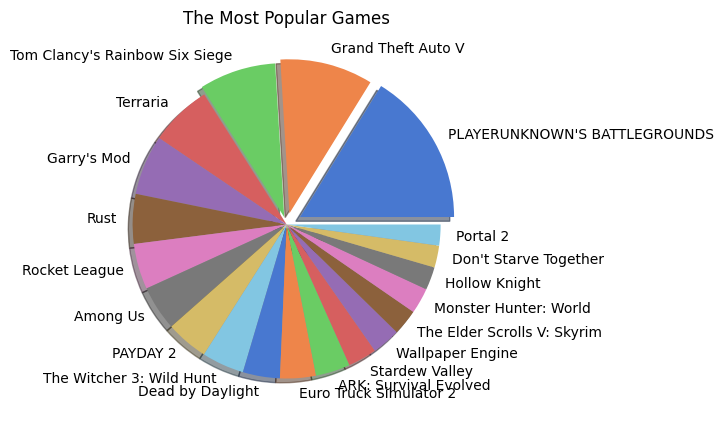

In [28]:
fig = plt.figure(figsize = (10,5))
colors = sns.color_palette("muted")
explode = (0.1,0.075,0.05,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)
plt.pie(x = app_counts["count"], labels = app_counts["app_name"], colors = colors,  explode = explode, shadow = True)
plt.title("The Most Popular Games")
plt.show()

### Percentage of TRUE Recommendation - highly recommended games

In [29]:
true_counts = data_rec.filter(data_rec["recommended"] == "true").groupBy("app_name").count()
recommended = true_counts.orderBy(true_counts["count"].desc()).limit(20)
recommended_apps = recommended.toPandas()
recommended_apps

23/12/12 14:29:32 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , app_id, app_name, review_id, language, timestamp_created, timestamp_updated, recommended, votes_helpful, votes_funny, weighted_vote_score, comment_count, steam_purchase, received_for_free, written_during_early_access, author.steamid, author.num_games_owned, author.num_reviews, author.playtime_forever, author.playtime_last_two_weeks, author.playtime_at_review, author.last_played
 Schema: _c0, app_id, app_name, review_id, language, timestamp_created, timestamp_updated, recommended, votes_helpful, votes_funny, weighted_vote_score, comment_count, steam_purchase, received_for_free, written_during_early_access, author.steamid, author.num_games_owned, author.num_reviews, author.playtime_forever, author.playtime_last_two_weeks, author.playtime_at_review, author.last_played
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/user/steam_analysis/steam_reviews.csv


,app_name,count
0,PLAYERUNKNOWN'S BATTLEGROUNDS,736903
1,Grand Theft Auto V,677035
2,Tom Clancy's Rainbow Six Siege,598865
3,Terraria,533816
4,Garry's Mod,507510
5,Among Us,376959
6,Rust,376374
7,Rocket League,363651
8,The Witcher 3: Wild Hunt,363301
9,PAYDAY 2,332298


In [30]:
true_apps = list(recommended_apps["app_name"])
true_app_counts = data_rec.filter(data_rec["app_name"].isin(true_apps)).groupBy("app_name").count()
true_app_counts = true_app_counts.orderBy(true_app_counts["count"].desc())

In [31]:
true_app_counts = true_app_counts.toPandas()
true_app_counts

23/12/12 14:29:56 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , app_id, app_name, review_id, language, timestamp_created, timestamp_updated, recommended, votes_helpful, votes_funny, weighted_vote_score, comment_count, steam_purchase, received_for_free, written_during_early_access, author.steamid, author.num_games_owned, author.num_reviews, author.playtime_forever, author.playtime_last_two_weeks, author.playtime_at_review, author.last_played
 Schema: _c0, app_id, app_name, review_id, language, timestamp_created, timestamp_updated, recommended, votes_helpful, votes_funny, weighted_vote_score, comment_count, steam_purchase, received_for_free, written_during_early_access, author.steamid, author.num_games_owned, author.num_reviews, author.playtime_forever, author.playtime_last_two_weeks, author.playtime_at_review, author.last_played
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/user/steam_analysis/steam_reviews.csv


,app_name,count
0,PLAYERUNKNOWN'S BATTLEGROUNDS,1357800
1,Grand Theft Auto V,818359
2,Tom Clancy's Rainbow Six Siege,675180
3,Terraria,547646
4,Garry's Mod,527440
5,Rust,437334
6,Rocket League,402244
7,Among Us,395229
8,PAYDAY 2,374256
9,The Witcher 3: Wild Hunt,371433


In [32]:
true_perc = []
for i in range(0,20,1):
    percent = (true_app_counts["count"][i]-recommended_apps["count"][i])/true_app_counts["count"][i]*100
    true_perc.append(percent)
recommended_apps["recommend_perc"] = true_perc

In [33]:
recommended_apps = recommended_apps.sort_values(by = "recommend_perc", ascending = False)
recommended_apps

,app_name,count,recommend_perc
0,PLAYERUNKNOWN'S BATTLEGROUNDS,736903,45.728163
12,Stardew Valley,246992,18.827663
1,Grand Theft Auto V,677035,17.269194
5,Among Us,376959,13.805238
16,Hollow Knight,195536,13.677881
11,Dead by Daylight,275021,12.676222
2,Tom Clancy's Rainbow Six Siege,598865,11.302912
9,PAYDAY 2,332298,10.536221
7,Rocket League,363651,7.989798
6,Rust,376374,6.431420


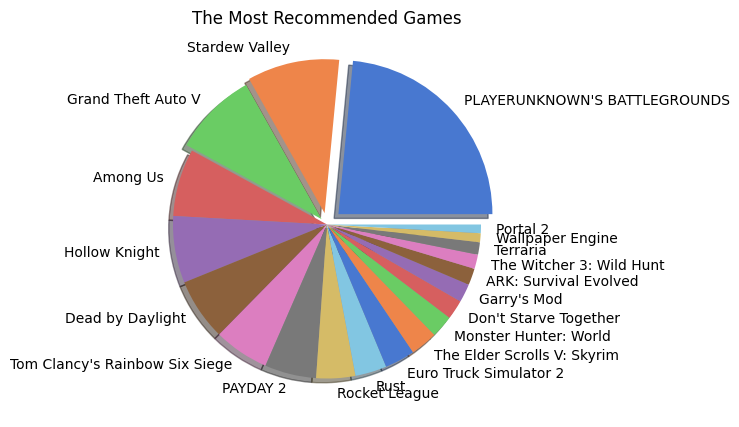

In [34]:
fig = plt.figure(figsize = (10,5))
colors = sns.color_palette("muted")
explode = (0.1,0.075,0.05,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)
plt.pie(x = recommended_apps["recommend_perc"], labels = recommended_apps["app_name"], colors = colors,  explode = explode, shadow = True)
plt.title("The Most Recommended Games")
plt.show()

## Demographic Analysis

#### Which language does most players use? Is there any linguistic trend in gaming - games, or review style?

- Using the `data_demo` data frame, we can easily extract the language details of the players and a trend in regional games.
- Also, we can extract a time-series trend among the players using different languages. For e.g., game A was in high demand in Schinese during the year YYYY depending on the timestamp of the review

In [35]:
data_demo.printSchema()

root
 |-- app_id: integer (nullable = true)
 |-- app_name: string (nullable = true)
 |-- review_id: string (nullable = true)
 |-- language: string (nullable = true)
 |-- author_steamid: long (nullable = true)
 |-- timestamp_created: timestamp (nullable = true)
 |-- author_playtime_forever: float (nullable = true)
 |-- recommended: boolean (nullable = true)



In [36]:
data_rec.select("app_name").distinct().count()

23/12/12 14:30:19 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , app_id, app_name, review_id, language, timestamp_created, timestamp_updated, recommended, votes_helpful, votes_funny, weighted_vote_score, comment_count, steam_purchase, received_for_free, written_during_early_access, author.steamid, author.num_games_owned, author.num_reviews, author.playtime_forever, author.playtime_last_two_weeks, author.playtime_at_review, author.last_played
 Schema: _c0, app_id, app_name, review_id, language, timestamp_created, timestamp_updated, recommended, votes_helpful, votes_funny, weighted_vote_score, comment_count, steam_purchase, received_for_free, written_during_early_access, author.steamid, author.num_games_owned, author.num_reviews, author.playtime_forever, author.playtime_last_two_weeks, author.playtime_at_review, author.last_played
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/user/steam_analysis/steam_reviews.csv


110497

In [37]:
data_rev.select("language").distinct().count()

23/12/12 14:30:45 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , app_id, app_name, review_id, language, timestamp_created, timestamp_updated, recommended, votes_helpful, votes_funny, weighted_vote_score, comment_count, steam_purchase, received_for_free, written_during_early_access, author.steamid, author.num_games_owned, author.num_reviews, author.playtime_forever, author.playtime_last_two_weeks, author.playtime_at_review, author.last_played
 Schema: _c0, app_id, app_name, review_id, language, timestamp_created, timestamp_updated, recommended, votes_helpful, votes_funny, weighted_vote_score, comment_count, steam_purchase, received_for_free, written_during_early_access, author.steamid, author.num_games_owned, author.num_reviews, author.playtime_forever, author.playtime_last_two_weeks, author.playtime_at_review, author.last_played
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/user/steam_analysis/steam_reviews.csv


110230

In [38]:
from pyspark.sql.functions import *

### Popular Review Languages

In [39]:
author_lang = data_demo.select(lower("language").alias("language")).groupBy("language").count().orderBy(col("count").desc()).limit(20).toPandas()

23/12/12 14:31:11 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , app_id, app_name, review_id, language, timestamp_created, timestamp_updated, recommended, votes_helpful, votes_funny, weighted_vote_score, comment_count, steam_purchase, received_for_free, written_during_early_access, author.steamid, author.num_games_owned, author.num_reviews, author.playtime_forever, author.playtime_last_two_weeks, author.playtime_at_review, author.last_played
 Schema: _c0, app_id, app_name, review_id, language, timestamp_created, timestamp_updated, recommended, votes_helpful, votes_funny, weighted_vote_score, comment_count, steam_purchase, received_for_free, written_during_early_access, author.steamid, author.num_games_owned, author.num_reviews, author.playtime_forever, author.playtime_last_two_weeks, author.playtime_at_review, author.last_played
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/user/steam_analysis/steam_reviews.csv


In [40]:
author_lang

,language,count
0,english,7317611
1,schinese,3098314
2,russian,1787351
3,brazilian,663413
4,spanish,624078
5,turkish,523773
6,german,522820
7,koreana,434338
8,polish,405074
9,french,390002


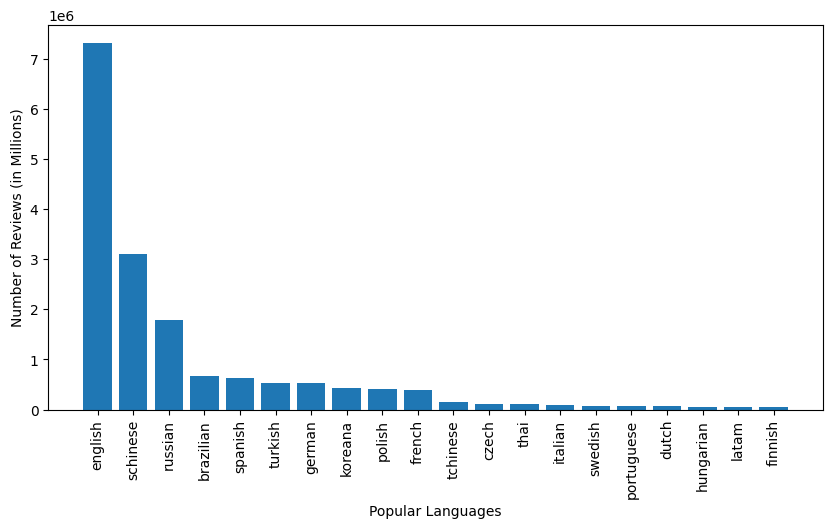

In [41]:
fig = plt.figure(figsize = (10,5))
plt.bar(author_lang["language"], author_lang["count"])
plt.xticks(rotation = 90)
plt.xlabel("Popular Languages")
plt.ylabel("Number of Reviews (in Millions)")
plt.show()

### Popular Games and Review Languages

In [42]:
data_demo_new = data_demo.select(lower("language").alias("language"), "app_id", "app_name", "review_id", "author_steamid", "timestamp_created" ,"recommended")
data_demo_new.show()

+--------+------+--------------------+---------+-----------------+-------------------+-----------+
|language|app_id|            app_name|review_id|   author_steamid|  timestamp_created|recommended|
+--------+------+--------------------+---------+-----------------+-------------------+-----------+
|schinese|292030|The Witcher 3: Wi...| 85185598|76561199095369542|2021-01-23 01:00:29|       true|
|schinese|292030|The Witcher 3: Wi...| 85185250|76561198949504115|2021-01-23 00:50:30|       true|
|schinese|292030|The Witcher 3: Wi...| 85185111|76561199090098988|2021-01-23 00:46:40|       true|
| english|292030|The Witcher 3: Wi...| 85184605|76561199054755373|2021-01-23 00:32:50|       true|
|schinese|292030|The Witcher 3: Wi...| 85184287|76561199028326951|2021-01-23 00:23:47|       true|
| english|292030|The Witcher 3: Wi...| 85184171|76561198170193529|2021-01-23 00:21:04|       true|
| english|292030|The Witcher 3: Wi...| 85184064|76561198119302812|2021-01-23 00:18:11|       true|
|schinese|

23/12/12 14:31:37 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , app_id, app_name, review_id, language, timestamp_created, timestamp_updated, recommended, votes_helpful, votes_funny, weighted_vote_score, comment_count, steam_purchase, received_for_free, written_during_early_access, author.steamid, author.num_games_owned, author.num_reviews, author.playtime_forever, author.playtime_last_two_weeks, author.playtime_at_review, author.last_played
 Schema: _c0, app_id, app_name, review_id, language, timestamp_created, timestamp_updated, recommended, votes_helpful, votes_funny, weighted_vote_score, comment_count, steam_purchase, received_for_free, written_during_early_access, author.steamid, author.num_games_owned, author.num_reviews, author.playtime_forever, author.playtime_last_two_weeks, author.playtime_at_review, author.last_played
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/user/steam_analysis/steam_reviews.csv


In [43]:
games_lang = data_demo_new.groupBy("app_name","language").count().orderBy(col("count").desc()).limit(100)

In [44]:
#games_lang.show()

In [45]:
games_lang_df = games_lang.toPandas()

23/12/12 14:31:37 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , app_id, app_name, review_id, language, timestamp_created, timestamp_updated, recommended, votes_helpful, votes_funny, weighted_vote_score, comment_count, steam_purchase, received_for_free, written_during_early_access, author.steamid, author.num_games_owned, author.num_reviews, author.playtime_forever, author.playtime_last_two_weeks, author.playtime_at_review, author.last_played
 Schema: _c0, app_id, app_name, review_id, language, timestamp_created, timestamp_updated, recommended, votes_helpful, votes_funny, weighted_vote_score, comment_count, steam_purchase, received_for_free, written_during_early_access, author.steamid, author.num_games_owned, author.num_reviews, author.playtime_forever, author.playtime_last_two_weeks, author.playtime_at_review, author.last_played
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/user/steam_analysis/steam_reviews.csv


In [46]:
games_lang_df

,app_name,language,count
0,PLAYERUNKNOWN'S BATTLEGROUNDS,schinese,729726
1,Terraria,english,306733
2,Tom Clancy's Rainbow Six Siege,english,300593
3,Garry's Mod,english,269605
4,Grand Theft Auto V,english,248992
...,...,...,...
95,Portal 2,russian,31058
96,Euro Truck Simulator 2,polish,30647
97,Age of Empires II (2013),english,30608
98,PLAYERUNKNOWN'S BATTLEGROUNDS,brazilian,30487


In [47]:
grouped_games_lang = games_lang_df.pivot(index='app_name', columns='language', values='count')

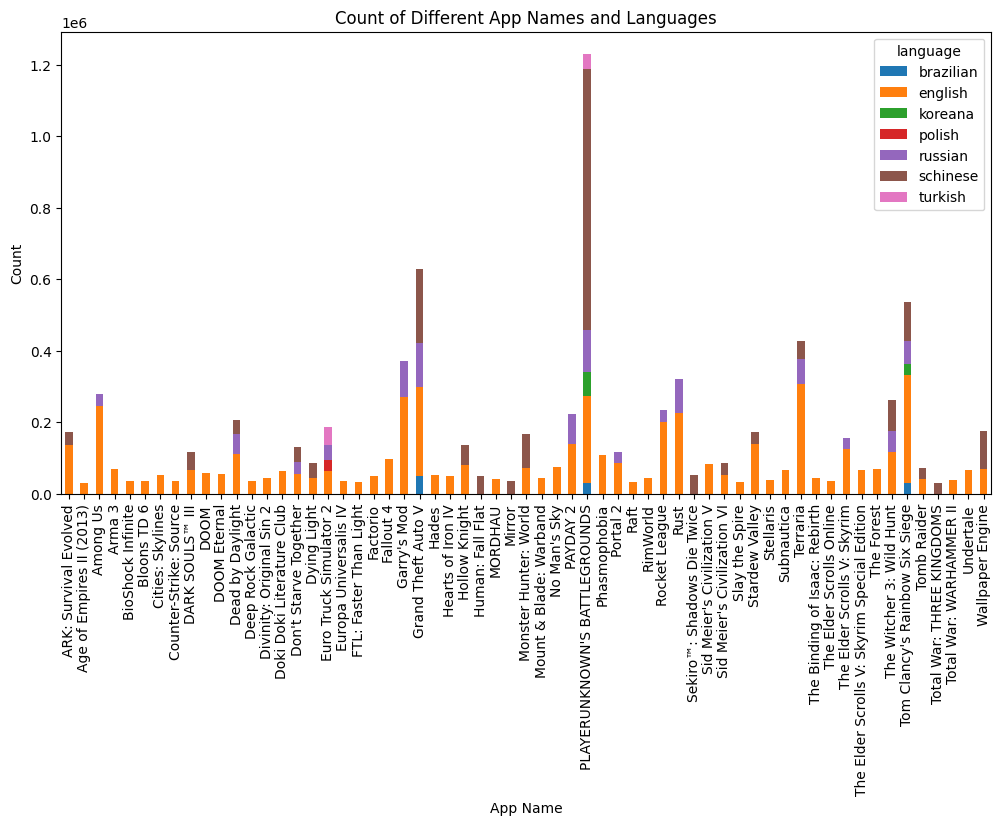

In [48]:
grouped_games_lang.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Count of Different App Names and Languages')
plt.xlabel('App Name')
plt.ylabel('Count')
plt.show()

## Time Analysis

### Review Trends for Popular Games over the months

How did the reviewing trend for games vary throughout the year of 2021?

In [49]:
def month_series_data(data, col, x):
    month_game_time = data.filter(month(col) == x)
    return month_game_time

In [50]:
# jan_game = month_series_data(data_demo,"timestamp_created",1).groupBy("app_name").count().orderBy(col("count").desc()).limit(10).toPandas()
# feb_game = month_series_data(data_demo,"timestamp_created",2).groupBy("app_name").count().orderBy(col("count").desc()).limit(10).toPandas()
# mar_game = month_series_data(data_demo,"timestamp_created",3).groupBy("app_name").count().orderBy(col("count").desc()).limit(10).toPandas()
# apr_game = month_series_data(data_demo,"timestamp_created",4).groupBy("app_name").count().orderBy(col("count").desc()).limit(10).toPandas()
# may_game = month_series_data(data_demo,"timestamp_created",5).groupBy("app_name").count().orderBy(col("count").desc()).limit(10).toPandas()
# jun_game = month_series_data(data_demo,"timestamp_created",6).groupBy("app_name").count().orderBy(col("count").desc()).limit(10).toPandas()
# jul_game = month_series_data(data_demo,"timestamp_created",7).groupBy("app_name").count().orderBy(col("count").desc()).limit(10).toPandas()
# aug_game = month_series_data(data_demo,"timestamp_created",8).groupBy("app_name").count().orderBy(col("count").desc()).limit(10).toPandas()
# sep_game = month_series_data(data_demo,"timestamp_created",9).groupBy("app_name").count().orderBy(col("count").desc()).limit(10).toPandas()
# oct_game = month_series_data(data_demo,"timestamp_created",10).groupBy("app_name").count().orderBy(col("count").desc()).limit(10).toPandas()
# nov_game = month_series_data(data_demo,"timestamp_created",11).groupBy("app_name").count().orderBy(col("count").desc()).limit(10).toPandas()
# dec_game = month_series_data(data_demo,"timestamp_created",12).groupBy("app_name").count().orderBy(col("count").desc()).limit(10).toPandas()

In [51]:
# jan_game.to_csv("jan_game.csv")
# feb_game.to_csv("feb_game.csv")
# mar_game.to_csv("mar_game.csv")
# apr_game.to_csv("apr_game.csv")
# may_game.to_csv("may_game.csv")
# jun_game.to_csv("jun_game.csv")
# jul_game.to_csv("jul_game.csv")
# aug_game.to_csv("aug_game.csv")
# sep_game.to_csv("sep_game.csv")
# oct_game.to_csv("oct_game.csv")
# nov_game.to_csv("nov_game.csv")
# dec_game.to_csv("dec_game.csv")

In [52]:
jan_game = pd.read_csv("jan_game.csv")
feb_game = pd.read_csv("feb_game.csv")
mar_game = pd.read_csv("mar_game.csv")
apr_game = pd.read_csv("apr_game.csv")
may_game = pd.read_csv("may_game.csv")
jun_game = pd.read_csv("jun_game.csv")
jul_game = pd.read_csv("jul_game.csv")
aug_game = pd.read_csv("aug_game.csv")
sep_game = pd.read_csv("sep_game.csv")
oct_game = pd.read_csv("oct_game.csv")
nov_game = pd.read_csv("nov_game.csv")
dec_game = pd.read_csv("dec_game.csv")

In [53]:
#jan_game

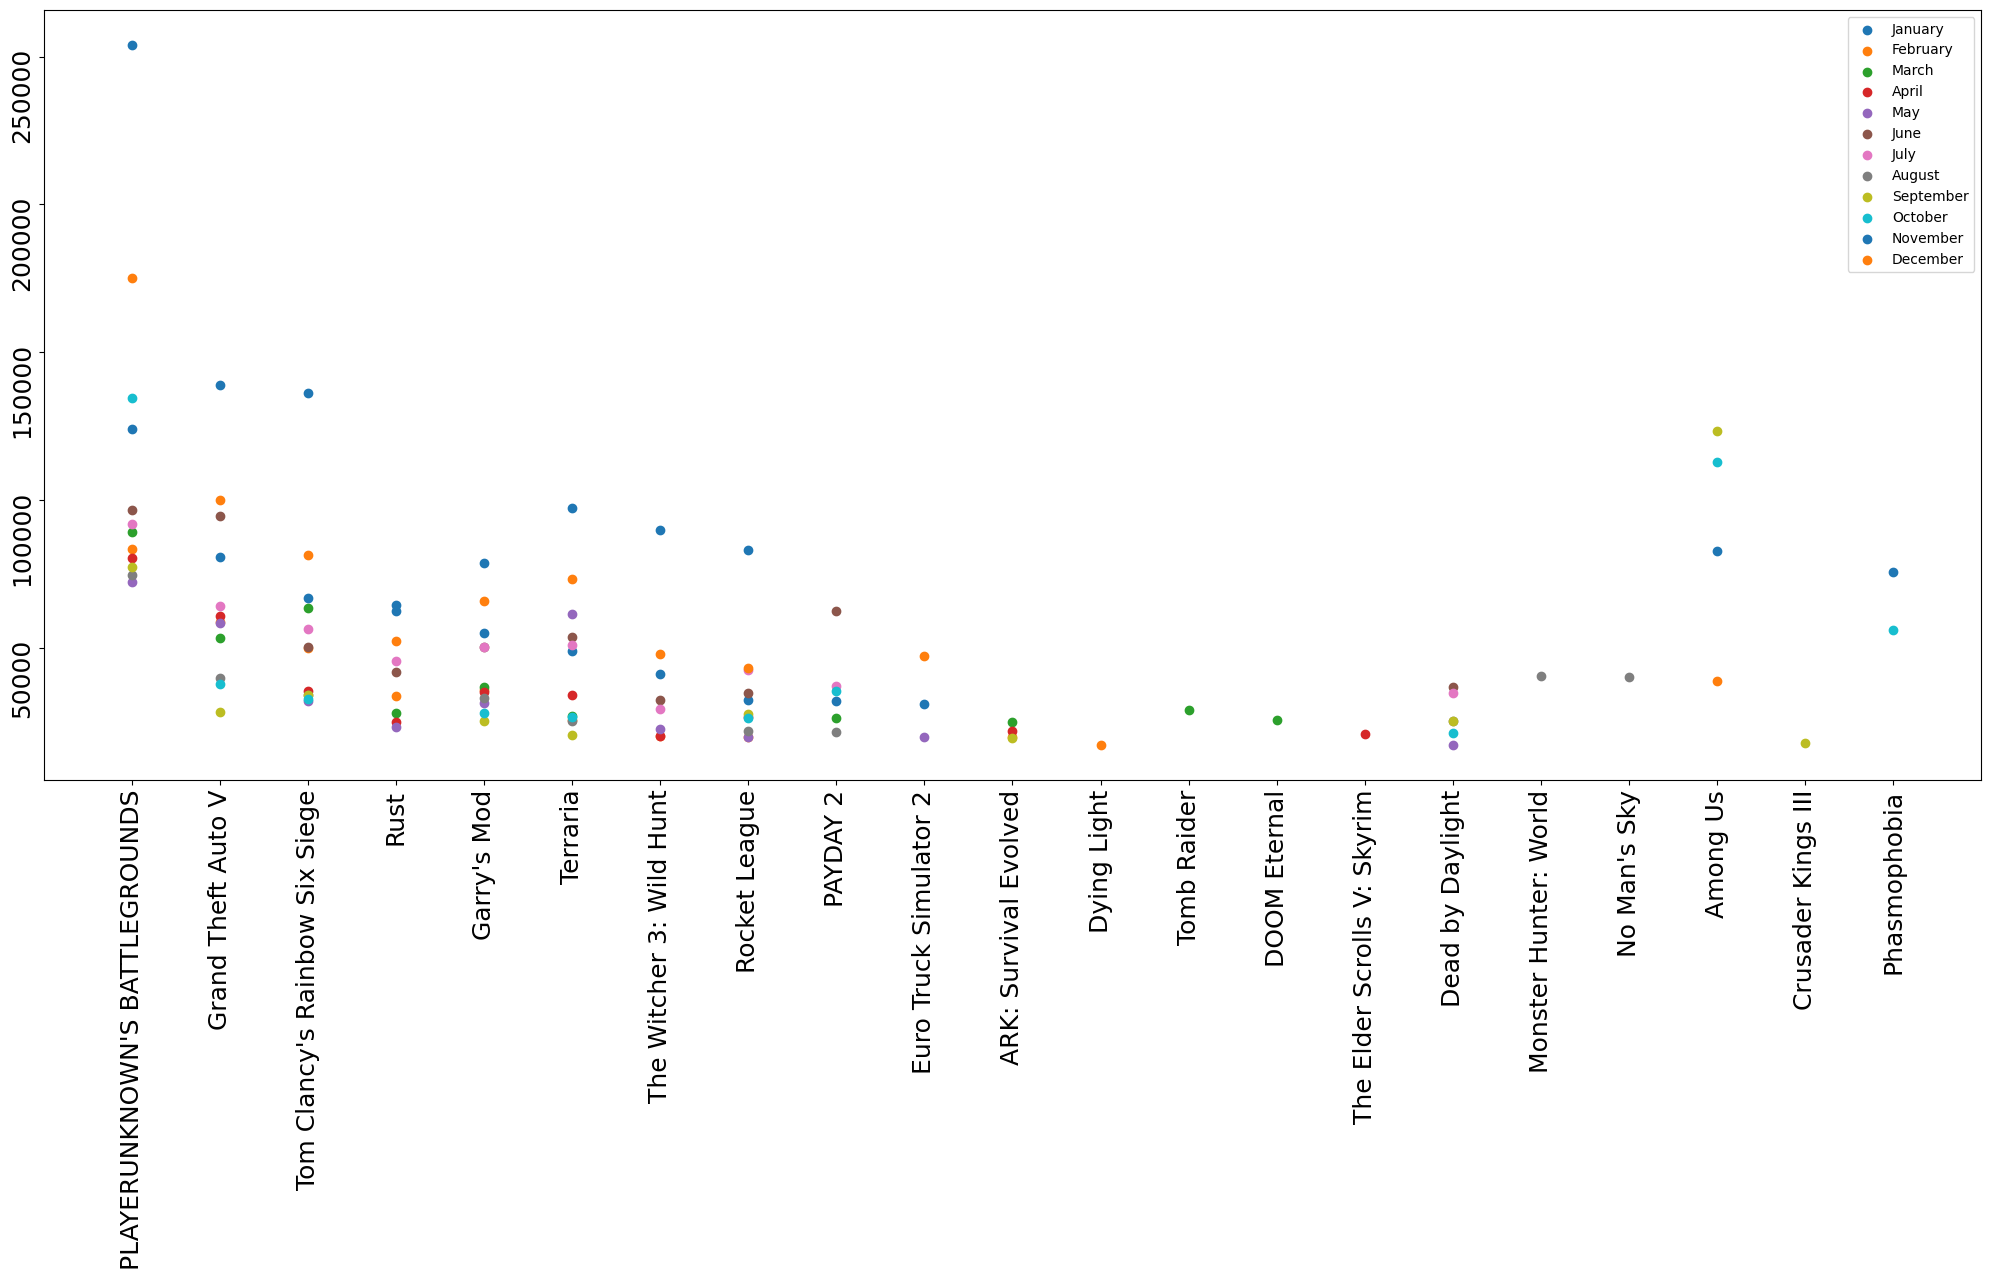

In [54]:
fig = plt.figure(figsize = (25,10 ))
plt.scatter(jan_game["app_name"],jan_game["count"], label = "January")
plt.scatter(feb_game["app_name"],feb_game["count"], label = "February")
plt.scatter(mar_game["app_name"],mar_game["count"], label = "March")
plt.scatter(apr_game["app_name"],apr_game["count"], label = "April")
plt.scatter(may_game["app_name"],may_game["count"], label = "May")
plt.scatter(jun_game["app_name"],jun_game["count"], label = "June")
plt.scatter(jul_game["app_name"],jul_game["count"], label = "July")
plt.scatter(aug_game["app_name"],aug_game["count"], label = "August")
plt.scatter(sep_game["app_name"],sep_game["count"], label = "September")
plt.scatter(oct_game["app_name"],oct_game["count"], label = "October")
plt.scatter(nov_game["app_name"],nov_game["count"], label = "November")
plt.scatter(dec_game["app_name"],dec_game["count"], label = "December")
plt.xticks(rotation = 90, fontsize = 18)
plt.yticks(rotation = 90, fontsize = 18)
plt.legend()
plt.show()

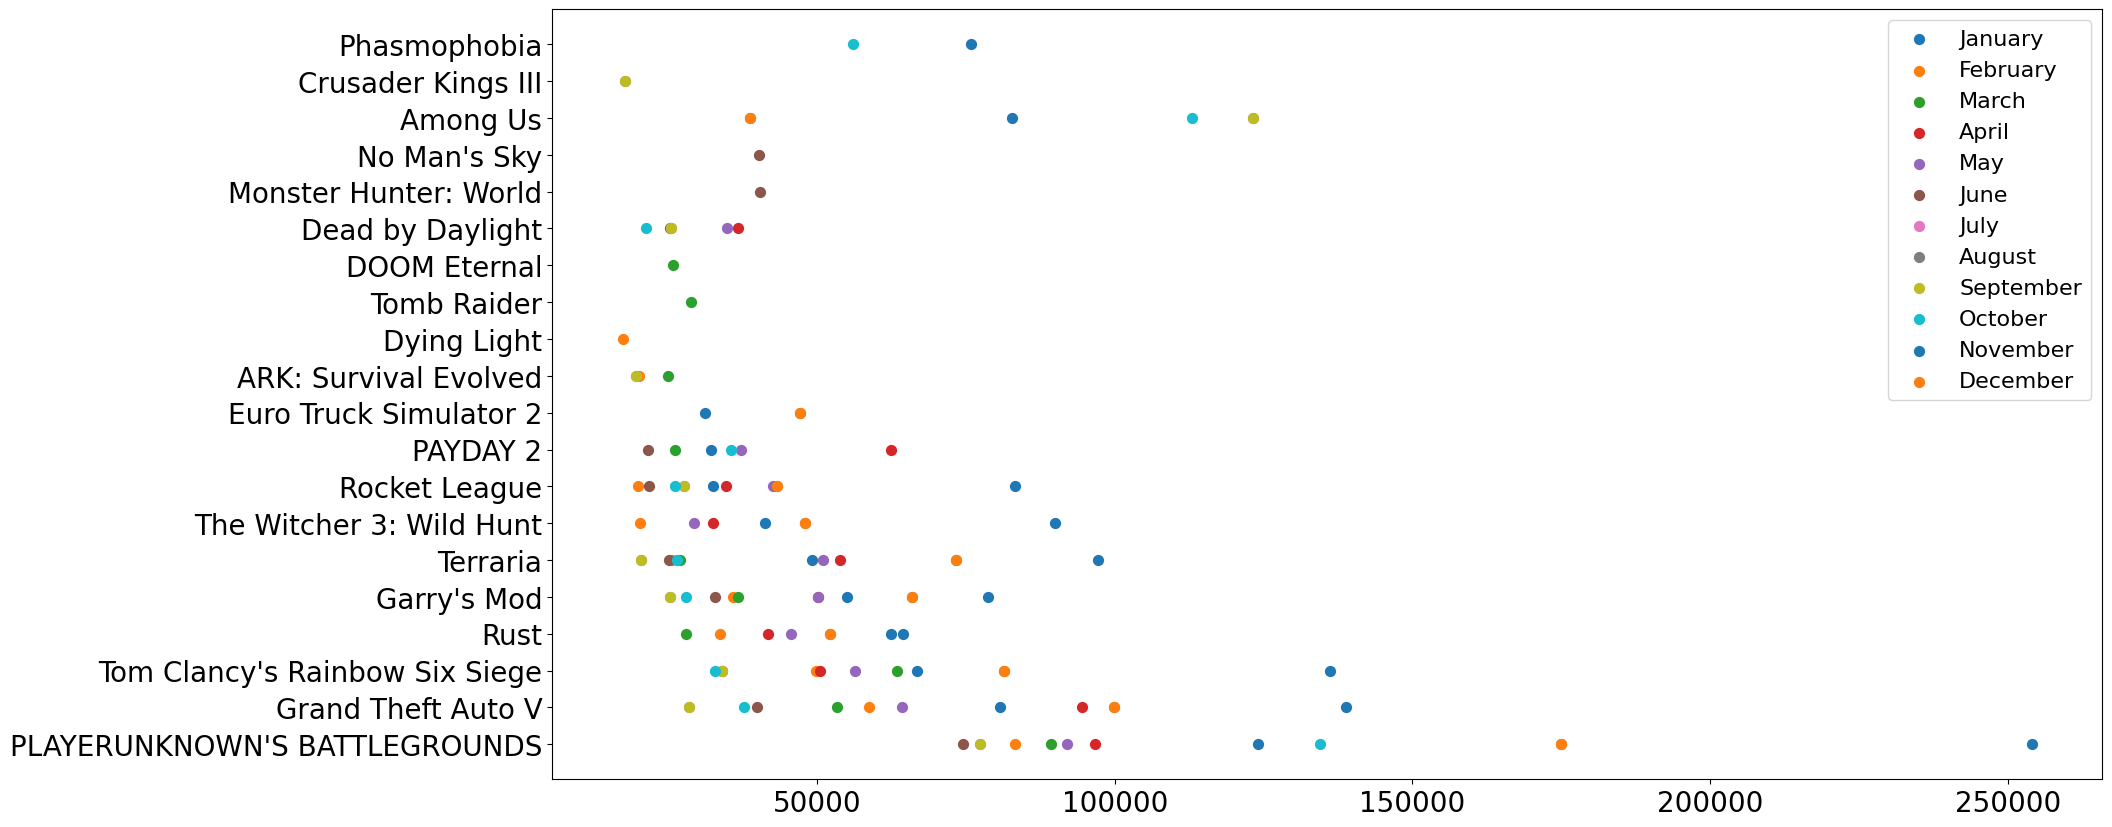

In [55]:
fig = plt.figure(figsize = (20,10))
plt.scatter(jan_game["count"],jan_game["app_name"], label = "January", s = 50)
plt.scatter(feb_game["count"],feb_game["app_name"], label = "February", s = 50)
plt.scatter(mar_game["count"],mar_game["app_name"], label = "March", s = 50)
plt.scatter(jun_game["count"],jun_game["app_name"], label = "April", s = 50)
plt.scatter(jul_game["count"],jul_game["app_name"], label = "May", s = 50)
plt.scatter(aug_game["count"],aug_game["app_name"], label = "June", s = 50)
plt.scatter(sep_game["count"],sep_game["app_name"], label = "July", s = 50)
plt.scatter(dec_game["count"],dec_game["app_name"], label = "August", s = 50)
plt.scatter(sep_game["count"],sep_game["app_name"], label = "September", s = 50)
plt.scatter(oct_game["count"],oct_game["app_name"], label = "October", s = 50)
plt.scatter(nov_game["count"],nov_game["app_name"], label = "November", s = 50)
plt.scatter(dec_game["count"],dec_game["app_name"], label = "December", s = 50)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize = 16)
plt.show()

### Trend of five most reviewed Games in each Quarter

In [56]:
pubg = data_demo.filter(col("app_name") == "PLAYERUNKNOWN'S BATTLEGROUNDS").groupBy("app_name",month("timestamp_created").alias("Month")).count().select("Month", "count").orderBy("Month").toPandas()
pubg = pubg.dropna()

23/12/12 14:32:07 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , app_id, app_name, review_id, language, timestamp_created, timestamp_updated, recommended, votes_helpful, votes_funny, weighted_vote_score, comment_count, steam_purchase, received_for_free, written_during_early_access, author.steamid, author.num_games_owned, author.num_reviews, author.playtime_forever, author.playtime_last_two_weeks, author.playtime_at_review, author.last_played
 Schema: _c0, app_id, app_name, review_id, language, timestamp_created, timestamp_updated, recommended, votes_helpful, votes_funny, weighted_vote_score, comment_count, steam_purchase, received_for_free, written_during_early_access, author.steamid, author.num_games_owned, author.num_reviews, author.playtime_forever, author.playtime_last_two_weeks, author.playtime_at_review, author.last_played
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/user/steam_analysis/steam_reviews.csv


In [57]:
#jan_game

In [58]:
gta5 = data_demo.filter(col("app_name") == "Grand Theft Auto V").groupBy("app_name",month("timestamp_created").alias("Month")).count().select("Month", "count").orderBy("Month").toPandas()
gta5 = gta5.dropna()

23/12/12 14:32:28 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , app_id, app_name, review_id, language, timestamp_created, timestamp_updated, recommended, votes_helpful, votes_funny, weighted_vote_score, comment_count, steam_purchase, received_for_free, written_during_early_access, author.steamid, author.num_games_owned, author.num_reviews, author.playtime_forever, author.playtime_last_two_weeks, author.playtime_at_review, author.last_played
 Schema: _c0, app_id, app_name, review_id, language, timestamp_created, timestamp_updated, recommended, votes_helpful, votes_funny, weighted_vote_score, comment_count, steam_purchase, received_for_free, written_during_early_access, author.steamid, author.num_games_owned, author.num_reviews, author.playtime_forever, author.playtime_last_two_weeks, author.playtime_at_review, author.last_played
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/user/steam_analysis/steam_reviews.csv


In [59]:
tom_clan = data_demo.filter(col("app_name") == "Tom Clancy's Rainbow Six Siege").groupBy("app_name",month("timestamp_created").alias("Month")).count().select("Month", "count").orderBy("Month").toPandas()
tom_clan = tom_clan.dropna()

23/12/12 14:32:49 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , app_id, app_name, review_id, language, timestamp_created, timestamp_updated, recommended, votes_helpful, votes_funny, weighted_vote_score, comment_count, steam_purchase, received_for_free, written_during_early_access, author.steamid, author.num_games_owned, author.num_reviews, author.playtime_forever, author.playtime_last_two_weeks, author.playtime_at_review, author.last_played
 Schema: _c0, app_id, app_name, review_id, language, timestamp_created, timestamp_updated, recommended, votes_helpful, votes_funny, weighted_vote_score, comment_count, steam_purchase, received_for_free, written_during_early_access, author.steamid, author.num_games_owned, author.num_reviews, author.playtime_forever, author.playtime_last_two_weeks, author.playtime_at_review, author.last_played
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/user/steam_analysis/steam_reviews.csv


In [60]:
rust = data_demo.filter(col("app_name") == "Rust").groupBy("app_name",month("timestamp_created").alias("Month")).count().select("Month", "count").orderBy("Month").toPandas()
rust = rust.dropna()

23/12/12 14:33:09 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , app_id, app_name, review_id, language, timestamp_created, timestamp_updated, recommended, votes_helpful, votes_funny, weighted_vote_score, comment_count, steam_purchase, received_for_free, written_during_early_access, author.steamid, author.num_games_owned, author.num_reviews, author.playtime_forever, author.playtime_last_two_weeks, author.playtime_at_review, author.last_played
 Schema: _c0, app_id, app_name, review_id, language, timestamp_created, timestamp_updated, recommended, votes_helpful, votes_funny, weighted_vote_score, comment_count, steam_purchase, received_for_free, written_during_early_access, author.steamid, author.num_games_owned, author.num_reviews, author.playtime_forever, author.playtime_last_two_weeks, author.playtime_at_review, author.last_played
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/user/steam_analysis/steam_reviews.csv


In [61]:
garrys = data_demo.filter(col("app_name") == "Garry's Mod").groupBy("app_name",month("timestamp_created").alias("Month")).count().select("Month", "count").orderBy("Month").toPandas()
garrys = garrys.dropna()

23/12/12 14:33:29 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , app_id, app_name, review_id, language, timestamp_created, timestamp_updated, recommended, votes_helpful, votes_funny, weighted_vote_score, comment_count, steam_purchase, received_for_free, written_during_early_access, author.steamid, author.num_games_owned, author.num_reviews, author.playtime_forever, author.playtime_last_two_weeks, author.playtime_at_review, author.last_played
 Schema: _c0, app_id, app_name, review_id, language, timestamp_created, timestamp_updated, recommended, votes_helpful, votes_funny, weighted_vote_score, comment_count, steam_purchase, received_for_free, written_during_early_access, author.steamid, author.num_games_owned, author.num_reviews, author.playtime_forever, author.playtime_last_two_weeks, author.playtime_at_review, author.last_played
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/user/steam_analysis/steam_reviews.csv


In [62]:
#apr_game

In [63]:
terraria = data_demo.filter(col("app_name") == "Terraria").groupBy("app_name",month("timestamp_created").alias("Month")).count().select("Month", "count").orderBy("Month").toPandas()
terraria = terraria.dropna()

23/12/12 14:33:50 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , app_id, app_name, review_id, language, timestamp_created, timestamp_updated, recommended, votes_helpful, votes_funny, weighted_vote_score, comment_count, steam_purchase, received_for_free, written_during_early_access, author.steamid, author.num_games_owned, author.num_reviews, author.playtime_forever, author.playtime_last_two_weeks, author.playtime_at_review, author.last_played
 Schema: _c0, app_id, app_name, review_id, language, timestamp_created, timestamp_updated, recommended, votes_helpful, votes_funny, weighted_vote_score, comment_count, steam_purchase, received_for_free, written_during_early_access, author.steamid, author.num_games_owned, author.num_reviews, author.playtime_forever, author.playtime_last_two_weeks, author.playtime_at_review, author.last_played
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/user/steam_analysis/steam_reviews.csv


In [64]:
#oct_game

In [65]:
among_us = data_demo.filter(col("app_name") == "Among Us").groupBy("app_name",month("timestamp_created").alias("Month")).count().select("Month", "count").orderBy("Month").toPandas()
among_us = among_us.dropna()

23/12/12 14:34:11 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , app_id, app_name, review_id, language, timestamp_created, timestamp_updated, recommended, votes_helpful, votes_funny, weighted_vote_score, comment_count, steam_purchase, received_for_free, written_during_early_access, author.steamid, author.num_games_owned, author.num_reviews, author.playtime_forever, author.playtime_last_two_weeks, author.playtime_at_review, author.last_played
 Schema: _c0, app_id, app_name, review_id, language, timestamp_created, timestamp_updated, recommended, votes_helpful, votes_funny, weighted_vote_score, comment_count, steam_purchase, received_for_free, written_during_early_access, author.steamid, author.num_games_owned, author.num_reviews, author.playtime_forever, author.playtime_last_two_weeks, author.playtime_at_review, author.last_played
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/user/steam_analysis/steam_reviews.csv


In [66]:
phasmo = data_demo.filter(col("app_name") == "Phasmophobia").groupBy("app_name",month("timestamp_created").alias("Month")).count().select("Month", "count").orderBy("Month").toPandas()
phasmo = phasmo.dropna()

23/12/12 14:34:32 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , app_id, app_name, review_id, language, timestamp_created, timestamp_updated, recommended, votes_helpful, votes_funny, weighted_vote_score, comment_count, steam_purchase, received_for_free, written_during_early_access, author.steamid, author.num_games_owned, author.num_reviews, author.playtime_forever, author.playtime_last_two_weeks, author.playtime_at_review, author.last_played
 Schema: _c0, app_id, app_name, review_id, language, timestamp_created, timestamp_updated, recommended, votes_helpful, votes_funny, weighted_vote_score, comment_count, steam_purchase, received_for_free, written_during_early_access, author.steamid, author.num_games_owned, author.num_reviews, author.playtime_forever, author.playtime_last_two_weeks, author.playtime_at_review, author.last_played
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/user/steam_analysis/steam_reviews.csv


In [67]:
payday2 = data_demo.filter(col("app_name") == "PAYDAY 2").groupBy("app_name",month("timestamp_created").alias("Month")).count().select("Month", "count").orderBy("Month").toPandas()
payday2 = payday2.dropna()

23/12/12 14:34:53 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , app_id, app_name, review_id, language, timestamp_created, timestamp_updated, recommended, votes_helpful, votes_funny, weighted_vote_score, comment_count, steam_purchase, received_for_free, written_during_early_access, author.steamid, author.num_games_owned, author.num_reviews, author.playtime_forever, author.playtime_last_two_weeks, author.playtime_at_review, author.last_played
 Schema: _c0, app_id, app_name, review_id, language, timestamp_created, timestamp_updated, recommended, votes_helpful, votes_funny, weighted_vote_score, comment_count, steam_purchase, received_for_free, written_during_early_access, author.steamid, author.num_games_owned, author.num_reviews, author.playtime_forever, author.playtime_last_two_weeks, author.playtime_at_review, author.last_played
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/user/steam_analysis/steam_reviews.csv


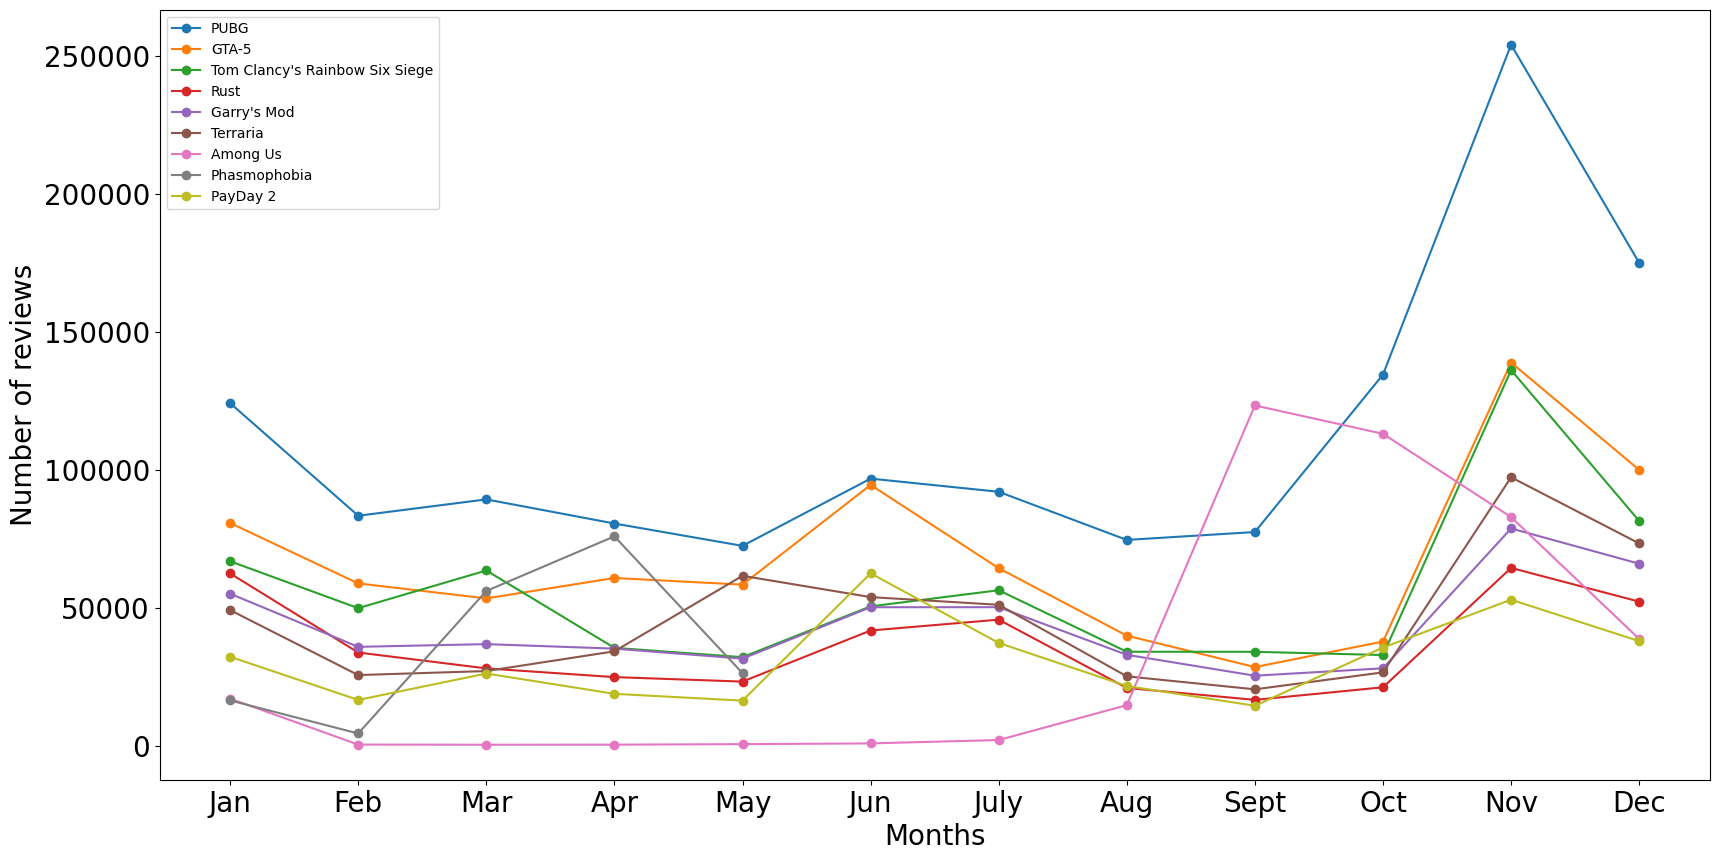

In [68]:
fig = plt.figure(figsize = (20, 10))
plt.plot(pubg["count"], marker = "o", label = "PUBG")
plt.plot(gta5["count"], marker = "o",label = "GTA-5")
plt.plot(tom_clan["count"], marker = "o",label = "Tom Clancy's Rainbow Six Siege")
plt.plot(rust["count"], marker = "o",label = "Rust")
plt.plot(garrys["count"], marker = "o",label = "Garry's Mod")
plt.plot(terraria["count"], marker = "o",label = "Terraria")
plt.plot(among_us["count"], marker = "o",label = "Among Us")
plt.plot(phasmo["count"], marker = "o",label = "Phasmophobia")
plt.plot(payday2[["count"]], marker = "o",label = "PayDay 2")
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.xlabel("Months", fontsize = 20)
plt.ylabel("Number of reviews",  fontsize = 20)
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "July", "Aug", "Sept", "Oct", "Nov", "Dec"]
plt.xticks(payday2["Month"], months)
plt.legend()
plt.show()

## Author Analysis

#### Are the reviewers dependable? Do they play a lot? Do they give reviews for different games?

- Using the `data_author` data frame, we can analyze the nature of the players.
- How long has the reviewer played and is it comparable with other reviewers?
- Find the number of reviews they have given

In [69]:
data_author.printSchema()

root
 |-- steam_purchase: boolean (nullable = true)
 |-- author_steamid: long (nullable = true)
 |-- author_num_games_owned: integer (nullable = true)
 |-- author_num_reviews: integer (nullable = true)
 |-- author_playtime_forever: float (nullable = true)
 |-- author_playtime_at_review: float (nullable = true)
 |-- author_last_played: timestamp (nullable = true)
 |-- recommended: boolean (nullable = true)



 ### Number of Games reviewed by each author

In [70]:
author_reviews_count = data_author.filter(col("author_steamid") >= 76560000000000000).groupBy("author_steamid").count().orderBy(col("count").desc()).limit(5000).toPandas()
author_reviews_count

23/12/12 14:35:14 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , app_id, app_name, review_id, language, timestamp_created, timestamp_updated, recommended, votes_helpful, votes_funny, weighted_vote_score, comment_count, steam_purchase, received_for_free, written_during_early_access, author.steamid, author.num_games_owned, author.num_reviews, author.playtime_forever, author.playtime_last_two_weeks, author.playtime_at_review, author.last_played
 Schema: _c0, app_id, app_name, review_id, language, timestamp_created, timestamp_updated, recommended, votes_helpful, votes_funny, weighted_vote_score, comment_count, steam_purchase, received_for_free, written_during_early_access, author.steamid, author.num_games_owned, author.num_reviews, author.playtime_forever, author.playtime_last_two_weeks, author.playtime_at_review, author.last_played
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/user/steam_analysis/steam_reviews.csv


,author_steamid,count
0,76561198315585536,128
1,76561198239163744,92
2,76561198038757354,76
3,76561198112669681,76
4,76561198057221241,71
...,...,...
4995,76561198102723684,20
4996,76561198287054338,20
4997,76561198093639977,20
4998,76561198296866910,20


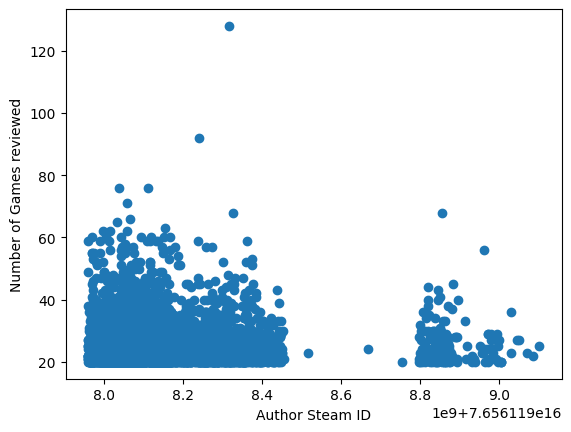

In [71]:
plt.scatter(author_reviews_count["author_steamid"], author_reviews_count["count"])
plt.xlabel("Author Steam ID")
plt.ylabel("Number of Games reviewed")
plt.show()

<Axes: xlabel='count'>

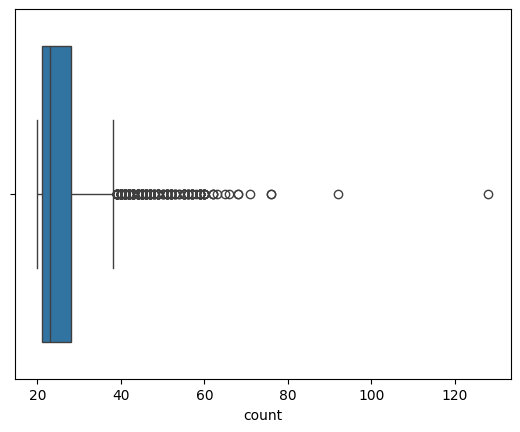

In [72]:
sns.boxplot(author_reviews_count["count"], orient = 'h')

## Playtime Analysis

In [76]:
author_playtime = data_author.filter(col("author_steamid") >= 76560000000000000).orderBy(col("author_playtime_forever").desc()).select("author_steamid","steam_purchase","author_num_games_owned","author_playtime_forever","author_playtime_at_review").limit(50).toPandas()
author_playtime

23/12/12 14:36:25 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , app_id, app_name, review_id, language, timestamp_created, timestamp_updated, recommended, votes_helpful, votes_funny, weighted_vote_score, comment_count, steam_purchase, received_for_free, written_during_early_access, author.steamid, author.num_games_owned, author.num_reviews, author.playtime_forever, author.playtime_last_two_weeks, author.playtime_at_review, author.last_played
 Schema: _c0, app_id, app_name, review_id, language, timestamp_created, timestamp_updated, recommended, votes_helpful, votes_funny, weighted_vote_score, comment_count, steam_purchase, received_for_free, written_during_early_access, author.steamid, author.num_games_owned, author.num_reviews, author.playtime_forever, author.playtime_last_two_weeks, author.playtime_at_review, author.last_played
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/user/steam_analysis/steam_reviews.csv


,author_steamid,steam_purchase,author_num_games_owned,author_playtime_forever,author_playtime_at_review
0,76561197992128065,False,1237,3744943.0,1608640.0
1,76561198030806709,False,2,3470649.0,3228103.0
2,76561198067113260,True,2723,3345621.0,1411495.0
3,76561198080500547,True,2,3336152.0,3062784.0
4,76561198042359209,False,863,2949310.0,825468.0
5,76561198090928556,False,12,2884967.0,2773429.0
6,76561197990503156,False,8,2870457.0,2110979.0
7,76561198063466231,False,13,2839534.0,1167229.0
8,76561198067483942,False,1963,2743310.0,64996.0
9,76561198030784974,False,7,2735000.0,716546.0


In [77]:
author_review_playtime = data_author.filter(col("author_steamid") >= 76560000000000000).orderBy(col("author_playtime_at_review").desc()).select("author_playtime_forever","author_playtime_at_review").limit(5000).toPandas()
author_review_playtime

23/12/12 14:36:53 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , app_id, app_name, review_id, language, timestamp_created, timestamp_updated, recommended, votes_helpful, votes_funny, weighted_vote_score, comment_count, steam_purchase, received_for_free, written_during_early_access, author.steamid, author.num_games_owned, author.num_reviews, author.playtime_forever, author.playtime_last_two_weeks, author.playtime_at_review, author.last_played
 Schema: _c0, app_id, app_name, review_id, language, timestamp_created, timestamp_updated, recommended, votes_helpful, votes_funny, weighted_vote_score, comment_count, steam_purchase, received_for_free, written_during_early_access, author.steamid, author.num_games_owned, author.num_reviews, author.playtime_forever, author.playtime_last_two_weeks, author.playtime_at_review, author.last_played
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/user/steam_analysis/steam_reviews.csv


,author_playtime_forever,author_playtime_at_review
0,3470649.0,3228103.0
1,3336152.0,3062784.0
2,2884967.0,2773429.0
3,2509321.0,2395854.0
4,2678555.0,2281155.0
...,...,...
4995,480153.0,416526.0
4996,467848.0,416485.0
4997,1233448.0,416458.0
4998,599303.0,416401.0


In [78]:
author_review_playtime["author_playtime_forever"] = author_review_playtime["author_playtime_forever"]/3600
author_review_playtime["author_playtime_at_review"] = author_review_playtime["author_playtime_at_review"]/3600

In [79]:
author_review_playtime #Converted to number of hours from number of seconds

,author_playtime_forever,author_playtime_at_review
0,964.069153,896.695251
1,926.708862,850.773315
2,801.379700,770.396973
3,697.033630,665.515015
4,744.043030,633.654175
...,...,...
4995,133.375839,115.701668
4996,129.957779,115.690277
4997,342.624451,115.682777
4998,166.473053,115.666946


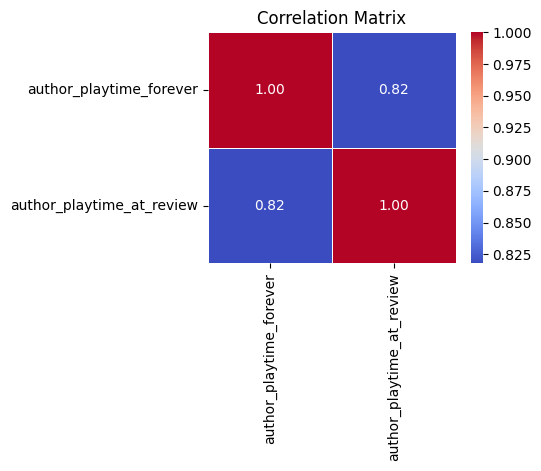

In [80]:
correlation_matrix = author_review_playtime.corr()
plt.figure(figsize=(4, 3))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

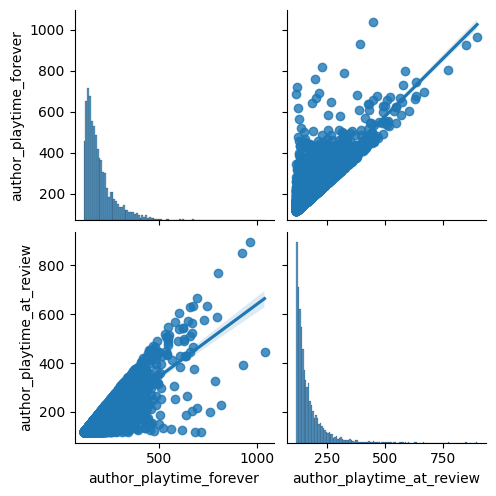

In [81]:
sns.pairplot(author_review_playtime, kind = "reg")
plt.show()


#### When do the players usually review the game? Just when they begin playing, or after a few days.

- Using `data_time` data frame, we can analyze the time taken by reviewers to review the game. This can help us understand how long players take to give recommendations and be used for asking for recommendations from new players.

In [82]:
data_time.printSchema()

root
 |-- app_id: integer (nullable = true)
 |-- app_name: string (nullable = true)
 |-- timestamp_created: timestamp (nullable = true)
 |-- timestamp_updated: timestamp (nullable = true)
 |-- author_playtime_at_review: float (nullable = true)
 |-- recommended: boolean (nullable = true)



In [83]:
author_review_playtime["author_playtime_after_review"] = (author_review_playtime["author_playtime_forever"] - author_review_playtime["author_playtime_at_review"])
author_review_playtime

,author_playtime_forever,author_playtime_at_review,author_playtime_after_review
0,964.069153,896.695251,67.373901
1,926.708862,850.773315,75.935547
2,801.379700,770.396973,30.982727
3,697.033630,665.515015,31.518616
4,744.043030,633.654175,110.388855
...,...,...,...
4995,133.375839,115.701668,17.674171
4996,129.957779,115.690277,14.267502
4997,342.624451,115.682777,226.941681
4998,166.473053,115.666946,50.806107


In [84]:
author_review_playtime["author_playtime_after_review"].mean()

35.161686

<Axes: xlabel='author_playtime_after_review'>

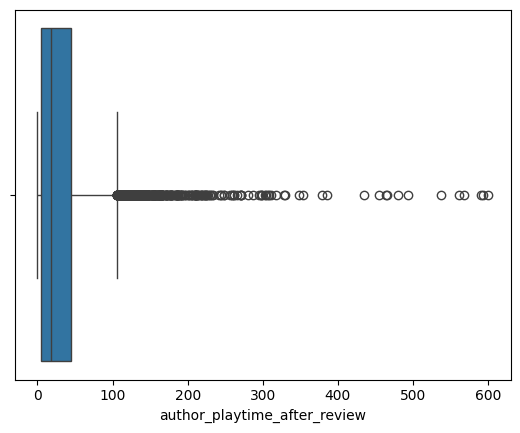

In [85]:
sns.boxplot(author_review_playtime["author_playtime_after_review"], orient = 'h', width = 0.9)

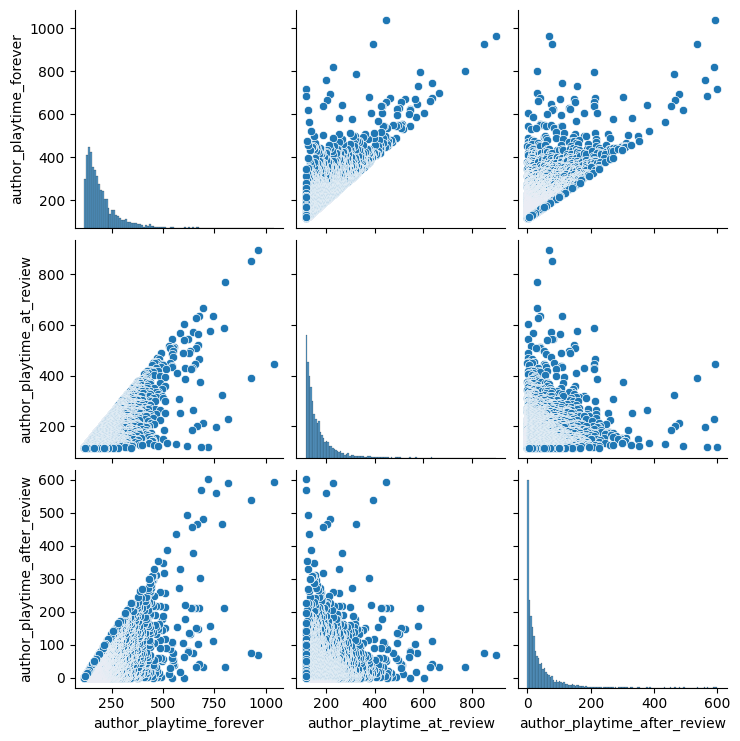

In [87]:
sns.pairplot(author_review_playtime, kind = "scatter")
plt.show()

#### How active are the players who give reviews? How long have they spent on the platform?

- Using `data_author` data frame, we can obtain how often a player gives a review and their correlation with the time spent on gaming.
- This analysis can be used in segmenting the gamers into different levels and giving offers and updates on purchases
- Average time spent on a game versus

In [88]:
print(author_review_playtime["author_playtime_after_review"].max())
print(author_review_playtime["author_playtime_after_review"].min())
print(author_review_playtime["author_playtime_after_review"].mean())
print(author_review_playtime["author_playtime_at_review"].max())
print(author_review_playtime["author_playtime_at_review"].min())
print(author_review_playtime["author_playtime_at_review"].mean())
print(author_review_playtime["author_playtime_forever"].max())
print(author_review_playtime["author_playtime_forever"].min())
print(author_review_playtime["author_playtime_forever"].mean())

600.3158
0.0
35.161686
896.69525
115.66639
167.06184
1040.262
115.75916
202.22354


<Axes: xlabel='author_playtime_forever'>

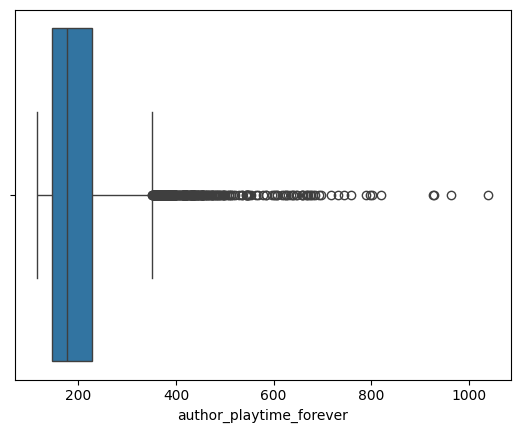

In [89]:
sns.boxplot(author_review_playtime["author_playtime_forever"], orient="h", width = 0.9)

<Axes: xlabel='author_playtime_at_review'>

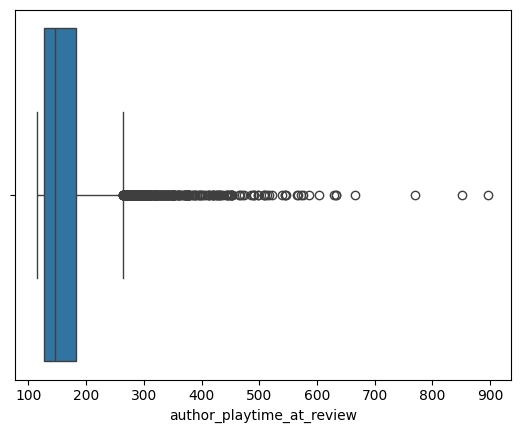

In [90]:
sns.boxplot(author_review_playtime["author_playtime_at_review"], orient="h", width = 0.9)

<Axes: xlabel='author_playtime_after_review'>

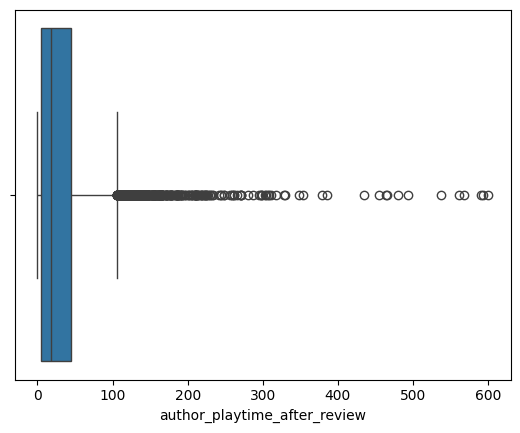

In [91]:
sns.boxplot(author_review_playtime["author_playtime_after_review"], orient="h", width = 0.9)

## Review Analysis

 - This part of the analysis gives an idea of how the true recommendations and the playtime are related. Does the players who give true recommendations tend to play longer?

In [92]:
data_review = data.filter(col("language") == "english").select("author_steamid","app_name","author_playtime_forever","recommended")
data_review.count()

23/12/12 14:37:23 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , app_id, app_name, review_id, language, timestamp_created, timestamp_updated, recommended, votes_helpful, votes_funny, weighted_vote_score, comment_count, steam_purchase, received_for_free, written_during_early_access, author.steamid, author.num_games_owned, author.num_reviews, author.playtime_forever, author.playtime_last_two_weeks, author.playtime_at_review, author.last_played
 Schema: _c0, app_id, app_name, review_id, language, timestamp_created, timestamp_updated, recommended, votes_helpful, votes_funny, weighted_vote_score, comment_count, steam_purchase, received_for_free, written_during_early_access, author.steamid, author.num_games_owned, author.num_reviews, author.playtime_forever, author.playtime_last_two_weeks, author.playtime_at_review, author.last_played
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/user/steam_analysis/steam_reviews.csv


7317611

In [93]:
data_review.show()

+-----------------+--------------------+-----------------------+-----------+
|   author_steamid|            app_name|author_playtime_forever|recommended|
+-----------------+--------------------+-----------------------+-----------+
|76561199054755373|The Witcher 3: Wi...|                 5587.0|       true|
|76561198170193529|The Witcher 3: Wi...|                  823.0|       true|
|76561198119302812|The Witcher 3: Wi...|                 4192.0|       true|
|76561198065591528|The Witcher 3: Wi...|                23329.0|       true|
|76561198996835044|The Witcher 3: Wi...|                 8557.0|       true|
|76561198040150323|The Witcher 3: Wi...|                  165.0|       true|
|76561198040190687|The Witcher 3: Wi...|                20168.0|       true|
|76561199001673284|The Witcher 3: Wi...|                 8068.0|       true|
|76561198033304276|The Witcher 3: Wi...|                 3159.0|       true|
|76561198116559597|The Witcher 3: Wi...|                  974.0|       true|

23/12/12 14:37:46 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , app_id, app_name, review_id, language, timestamp_created, timestamp_updated, recommended, votes_helpful, votes_funny, weighted_vote_score, comment_count, steam_purchase, received_for_free, written_during_early_access, author.steamid, author.num_games_owned, author.num_reviews, author.playtime_forever, author.playtime_last_two_weeks, author.playtime_at_review, author.last_played
 Schema: _c0, app_id, app_name, review_id, language, timestamp_created, timestamp_updated, recommended, votes_helpful, votes_funny, weighted_vote_score, comment_count, steam_purchase, received_for_free, written_during_early_access, author.steamid, author.num_games_owned, author.num_reviews, author.playtime_forever, author.playtime_last_two_weeks, author.playtime_at_review, author.last_played
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/user/steam_analysis/steam_reviews.csv


In [94]:
reviews = data_review.limit(50000).toPandas()

23/12/12 14:37:46 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , app_id, app_name, review_id, language, timestamp_created, timestamp_updated, recommended, votes_helpful, votes_funny, weighted_vote_score, comment_count, steam_purchase, received_for_free, written_during_early_access, author.steamid, author.num_games_owned, author.num_reviews, author.playtime_forever, author.playtime_last_two_weeks, author.playtime_at_review, author.last_played
 Schema: _c0, app_id, app_name, review_id, language, timestamp_created, timestamp_updated, recommended, votes_helpful, votes_funny, weighted_vote_score, comment_count, steam_purchase, received_for_free, written_during_early_access, author.steamid, author.num_games_owned, author.num_reviews, author.playtime_forever, author.playtime_last_two_weeks, author.playtime_at_review, author.last_played
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/user/steam_analysis/steam_reviews.csv


In [95]:
reviews = reviews.dropna()
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49807 entries, 0 to 49999
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   author_steamid           49807 non-null  float64
 1   app_name                 49807 non-null  object 
 2   author_playtime_forever  49807 non-null  float32
 3   recommended              49807 non-null  object 
dtypes: float32(1), float64(1), object(2)
memory usage: 1.7+ MB


In [96]:
reviews["author_playtime_forever"] = reviews["author_playtime_forever"]/3600

<Axes: xlabel='author_playtime_forever', ylabel='recommended'>

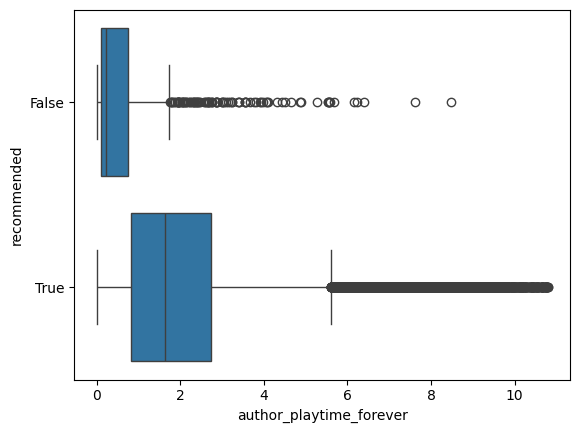

In [97]:
z_scores = stats.zscore(reviews["author_playtime_forever"])
outlier_threshold = 3
df_no_outliers = reviews[(z_scores < outlier_threshold) & (z_scores > -outlier_threshold)]
sns.boxplot(y = "recommended", x = "author_playtime_forever", data = df_no_outliers, orient = 'h')

## Game Recommendation using ALS (Alternating Least Squares) Spark ML Library

#### Are there any pairs of games that are played by the same players, i.e., if player A plays game X, then there is a good chance they play game Y also? Analyze any pattern

- Using the `data_demo` data frame, we can extract the review authors who have given reviews for more than one game.
- We will use the `author_playtime_forever` column to filter the gamers with a play time more than average so as to decrease the amassing of games by a single author.
- We will consider five games that are common among these reviewers and recommend them to other players who would fall in the same category.

In [98]:
data_demo.printSchema()

root
 |-- app_id: integer (nullable = true)
 |-- app_name: string (nullable = true)
 |-- review_id: string (nullable = true)
 |-- language: string (nullable = true)
 |-- author_steamid: long (nullable = true)
 |-- timestamp_created: timestamp (nullable = true)
 |-- author_playtime_forever: float (nullable = true)
 |-- recommended: boolean (nullable = true)



In [109]:
def remove_outliers(df, column):
    q1, q3 = df.approxQuantile(column, [0.25, 0.75], 0.01)
    iqr = q3 - q1
    lower_limit = q1 - 2 * iqr
    upper_limit = q3 + 2 * iqr
    return df.filter((col(column) >= lower_limit) & (col(column) <= upper_limit))
data_demo = remove_outliers(data_demo, "author_playtime_forever")
mean_playtime = data_demo.agg(mean("author_playtime_forever").alias("Mean")).collect()[0]["Mean"]

23/12/12 14:43:27 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , app_id, app_name, review_id, language, timestamp_created, timestamp_updated, recommended, votes_helpful, votes_funny, weighted_vote_score, comment_count, steam_purchase, received_for_free, written_during_early_access, author.steamid, author.num_games_owned, author.num_reviews, author.playtime_forever, author.playtime_last_two_weeks, author.playtime_at_review, author.last_played
 Schema: _c0, app_id, app_name, review_id, language, timestamp_created, timestamp_updated, recommended, votes_helpful, votes_funny, weighted_vote_score, comment_count, steam_purchase, received_for_free, written_during_early_access, author.steamid, author.num_games_owned, author.num_reviews, author.playtime_forever, author.playtime_last_two_weeks, author.playtime_at_review, author.last_played
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/user/steam_analysis/steam_reviews.csv
23/12/12 14:43:59 WARN CSVHeaderC

In [110]:
mean_playtime/3600 # average play time in hours

2.072809526402556

In [111]:
pair_games = data_demo.filter(col("author_playtime_forever")>=5*mean_playtime).groupBy("author_steamid").count()
pair_games = pair_games.filter((pair_games["count"]>1)&(pair_games["author_steamid"]>=76560000000000000)).orderBy(pair_games["count"].desc())
pair_games.show()

23/12/12 14:44:30 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , app_id, app_name, review_id, language, timestamp_created, timestamp_updated, recommended, votes_helpful, votes_funny, weighted_vote_score, comment_count, steam_purchase, received_for_free, written_during_early_access, author.steamid, author.num_games_owned, author.num_reviews, author.playtime_forever, author.playtime_last_two_weeks, author.playtime_at_review, author.last_played
 Schema: _c0, app_id, app_name, review_id, language, timestamp_created, timestamp_updated, recommended, votes_helpful, votes_funny, weighted_vote_score, comment_count, steam_purchase, received_for_free, written_during_early_access, author.steamid, author.num_games_owned, author.num_reviews, author.playtime_forever, author.playtime_last_two_weeks, author.playtime_at_review, author.last_played
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/user/steam_analysis/steam_reviews.csv


+-----------------+-----+
|   author_steamid|count|
+-----------------+-----+
|76561199003745475|   10|
|76561198303461537|    6|
|76561198107639116|    5|
|76561198008966571|    5|
|76561198847533327|    5|
|76561198126042274|    4|
|76561198262809392|    4|
|76561198368118101|    4|
|76561198119696900|    4|
|76561198053974624|    4|
|76561198265166280|    4|
|76561198419862022|    3|
|76561198193335718|    3|
|76561198022310189|    3|
|76561198217879381|    3|
|76561198056543838|    3|
|76561197987143109|    3|
|76561198126942964|    3|
|76561198152169974|    3|
|76561198357749095|    3|
+-----------------+-----+
only showing top 20 rows



In [112]:
pair_games.count()

23/12/12 14:45:10 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , app_id, app_name, review_id, language, timestamp_created, timestamp_updated, recommended, votes_helpful, votes_funny, weighted_vote_score, comment_count, steam_purchase, received_for_free, written_during_early_access, author.steamid, author.num_games_owned, author.num_reviews, author.playtime_forever, author.playtime_last_two_weeks, author.playtime_at_review, author.last_played
 Schema: _c0, app_id, app_name, review_id, language, timestamp_created, timestamp_updated, recommended, votes_helpful, votes_funny, weighted_vote_score, comment_count, steam_purchase, received_for_free, written_during_early_access, author.steamid, author.num_games_owned, author.num_reviews, author.playtime_forever, author.playtime_last_two_weeks, author.playtime_at_review, author.last_played
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/user/steam_analysis/steam_reviews.csv


2426

In [113]:
new_pair_games = data_demo.filter(col("author_playtime_forever")>=5*mean_playtime)
new_pair_games = new_pair_games.filter(new_pair_games["author_steamid"]>=76560000000000000).select("author_steamid","app_id", "app_name","recommended")
new_pair_games.show()

23/12/12 14:45:37 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , app_id, app_name, review_id, language, timestamp_created, timestamp_updated, recommended, votes_helpful, votes_funny, weighted_vote_score, comment_count, steam_purchase, received_for_free, written_during_early_access, author.steamid, author.num_games_owned, author.num_reviews, author.playtime_forever, author.playtime_last_two_weeks, author.playtime_at_review, author.last_played
 Schema: _c0, app_id, app_name, review_id, language, timestamp_created, timestamp_updated, recommended, votes_helpful, votes_funny, weighted_vote_score, comment_count, steam_purchase, received_for_free, written_during_early_access, author.steamid, author.num_games_owned, author.num_reviews, author.playtime_forever, author.playtime_last_two_weeks, author.playtime_at_review, author.last_played
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/user/steam_analysis/steam_reviews.csv


+-----------------+------+--------------------+-----------+
|   author_steamid|app_id|            app_name|recommended|
+-----------------+------+--------------------+-----------+
|76561197965084790|292030|The Witcher 3: Wi...|       true|
|76561198107766321|292030|The Witcher 3: Wi...|       true|
|76561198135711109|292030|The Witcher 3: Wi...|       true|
|76561198037177808|292030|The Witcher 3: Wi...|       true|
|76561198042237824|292030|The Witcher 3: Wi...|       true|
|76561198042901664|292030|The Witcher 3: Wi...|      false|
|76561198036727010|292030|The Witcher 3: Wi...|       true|
|76561198054683422|292030|The Witcher 3: Wi...|       true|
|76561198100379915|292030|The Witcher 3: Wi...|       true|
|76561198305269510|292030|The Witcher 3: Wi...|       true|
|76561198049879170|292030|The Witcher 3: Wi...|       true|
|76561198050122816|292030|The Witcher 3: Wi...|       true|
|76561199014048285|292030|The Witcher 3: Wi...|       true|
|76561198032748891|292030|The Witcher 3:

In [114]:
new_pair_games.count()

23/12/12 14:45:37 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , app_id, app_name, review_id, language, timestamp_created, timestamp_updated, recommended, votes_helpful, votes_funny, weighted_vote_score, comment_count, steam_purchase, received_for_free, written_during_early_access, author.steamid, author.num_games_owned, author.num_reviews, author.playtime_forever, author.playtime_last_two_weeks, author.playtime_at_review, author.last_played
 Schema: _c0, app_id, app_name, review_id, language, timestamp_created, timestamp_updated, recommended, votes_helpful, votes_funny, weighted_vote_score, comment_count, steam_purchase, received_for_free, written_during_early_access, author.steamid, author.num_games_owned, author.num_reviews, author.playtime_forever, author.playtime_last_two_weeks, author.playtime_at_review, author.last_played
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/user/steam_analysis/steam_reviews.csv


259828

In [115]:
# Convert author_steamid and app_id to indices
author_indexer = StringIndexer(inputCol="author_steamid", outputCol="author_index").fit(new_pair_games)
app_indexer = StringIndexer(inputCol="app_name", outputCol="app_index").fit(new_pair_games)
new_pair_games = new_pair_games.withColumn("Rating", when(col("recommended") == True, 5).otherwise(1))

23/12/12 14:46:04 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , app_id, app_name, review_id, language, timestamp_created, timestamp_updated, recommended, votes_helpful, votes_funny, weighted_vote_score, comment_count, steam_purchase, received_for_free, written_during_early_access, author.steamid, author.num_games_owned, author.num_reviews, author.playtime_forever, author.playtime_last_two_weeks, author.playtime_at_review, author.last_played
 Schema: _c0, app_id, app_name, review_id, language, timestamp_created, timestamp_updated, recommended, votes_helpful, votes_funny, weighted_vote_score, comment_count, steam_purchase, received_for_free, written_during_early_access, author.steamid, author.num_games_owned, author.num_reviews, author.playtime_forever, author.playtime_last_two_weeks, author.playtime_at_review, author.last_played
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/user/steam_analysis/steam_reviews.csv
23/12/12 14:46:33 WARN CSVHeaderC

In [116]:
new_pair = author_indexer.transform(app_indexer.transform(new_pair_games))
new_pair.show()

23/12/12 14:47:01 WARN DAGScheduler: Broadcasting large task binary with size 10.6 MiB
23/12/12 14:47:01 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , app_id, app_name, review_id, language, timestamp_created, timestamp_updated, recommended, votes_helpful, votes_funny, weighted_vote_score, comment_count, steam_purchase, received_for_free, written_during_early_access, author.steamid, author.num_games_owned, author.num_reviews, author.playtime_forever, author.playtime_last_two_weeks, author.playtime_at_review, author.last_played
 Schema: _c0, app_id, app_name, review_id, language, timestamp_created, timestamp_updated, recommended, votes_helpful, votes_funny, weighted_vote_score, comment_count, steam_purchase, received_for_free, written_during_early_access, author.steamid, author.num_games_owned, author.num_reviews, author.playtime_forever, author.playtime_last_two_weeks, author.playtime_at_review, author.last_played
Expected: _c0 but found: 
CSV file: hdfs:/

+-----------------+------+--------------------+-----------+------+---------+------------+
|   author_steamid|app_id|            app_name|recommended|Rating|app_index|author_index|
+-----------------+------+--------------------+-----------+------+---------+------------+
|76561197965084790|292030|The Witcher 3: Wi...|       true|     5|     28.0|      3677.0|
|76561198107766321|292030|The Witcher 3: Wi...|       true|     5|     28.0|     82706.0|
|76561198135711109|292030|The Witcher 3: Wi...|       true|     5|     28.0|    101230.0|
|76561198037177808|292030|The Witcher 3: Wi...|       true|     5|     28.0|     32851.0|
|76561198042237824|292030|The Witcher 3: Wi...|       true|     5|     28.0|     36143.0|
|76561198042901664|292030|The Witcher 3: Wi...|      false|     1|     28.0|     36684.0|
|76561198036727010|292030|The Witcher 3: Wi...|       true|     5|     28.0|     32611.0|
|76561198054683422|292030|The Witcher 3: Wi...|       true|     5|     28.0|     45106.0|
|765611981

In [117]:
games = new_pair.select("app_index","app_name").distinct().orderBy("app_index")
games.count()

23/12/12 14:47:02 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , app_id, app_name, review_id, language, timestamp_created, timestamp_updated, recommended, votes_helpful, votes_funny, weighted_vote_score, comment_count, steam_purchase, received_for_free, written_during_early_access, author.steamid, author.num_games_owned, author.num_reviews, author.playtime_forever, author.playtime_last_two_weeks, author.playtime_at_review, author.last_played
 Schema: _c0, app_id, app_name, review_id, language, timestamp_created, timestamp_updated, recommended, votes_helpful, votes_funny, weighted_vote_score, comment_count, steam_purchase, received_for_free, written_during_early_access, author.steamid, author.num_games_owned, author.num_reviews, author.playtime_forever, author.playtime_last_two_weeks, author.playtime_at_review, author.last_played
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/user/steam_analysis/steam_reviews.csv


847

In [118]:
# Create an ALS (Alternating Least Squares) model
als = ALS(maxIter=10, regParam=0.01, userCol="app_index", itemCol="author_index", ratingCol="Rating", coldStartStrategy="drop")

# Fit the model to the data
model = als.fit(new_pair)

# Generate recommendations for all items
app_recommendations = model.recommendForAllItems(5)  # Number of recommendations per item

# Display the recommendations
app_recommendations.show(truncate=False)

23/12/12 14:47:32 WARN DAGScheduler: Broadcasting large task binary with size 10.6 MiB
23/12/12 14:47:32 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , app_id, app_name, review_id, language, timestamp_created, timestamp_updated, recommended, votes_helpful, votes_funny, weighted_vote_score, comment_count, steam_purchase, received_for_free, written_during_early_access, author.steamid, author.num_games_owned, author.num_reviews, author.playtime_forever, author.playtime_last_two_weeks, author.playtime_at_review, author.last_played
 Schema: _c0, app_id, app_name, review_id, language, timestamp_created, timestamp_updated, recommended, votes_helpful, votes_funny, weighted_vote_score, comment_count, steam_purchase, received_for_free, written_during_early_access, author.steamid, author.num_games_owned, author.num_reviews, author.playtime_forever, author.playtime_last_two_weeks, author.playtime_at_review, author.last_played
Expected: _c0 but found: 
CSV file: hdfs:/

+------------+-----------------------------------------------------------------------------------------+
|author_index|recommendations                                                                          |
+------------+-----------------------------------------------------------------------------------------+
|26          |[{545, 5.110069}, {23, 5.0741754}, {32, 4.9596233}, {16, 4.921337}, {236, 4.593187}]     |
|27          |[{124, 7.9713182}, {61, 7.3510895}, {659, 7.1857305}, {519, 7.1357174}, {480, 7.0634856}]|
|28          |[{252, 6.4423847}, {212, 6.064964}, {528, 5.785183}, {519, 5.609013}, {108, 5.532746}]   |
|31          |[{140, 6.260532}, {108, 5.997504}, {211, 5.6662126}, {558, 5.578244}, {116, 5.475158}]   |
|34          |[{631, 5.137752}, {0, 4.973231}, {7, 4.961696}, {4, 4.9556036}, {321, 4.827304}]         |
|44          |[{428, 6.420355}, {320, 5.9340463}, {101, 5.7874656}, {845, 5.6964426}, {225, 5.6908174}]|
|53          |[{702, 5.6680846}, {324, 5.264774}, {690,

In [119]:
games.show()

23/12/12 14:48:49 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , app_id, app_name, review_id, language, timestamp_created, timestamp_updated, recommended, votes_helpful, votes_funny, weighted_vote_score, comment_count, steam_purchase, received_for_free, written_during_early_access, author.steamid, author.num_games_owned, author.num_reviews, author.playtime_forever, author.playtime_last_two_weeks, author.playtime_at_review, author.last_played
 Schema: _c0, app_id, app_name, review_id, language, timestamp_created, timestamp_updated, recommended, votes_helpful, votes_funny, weighted_vote_score, comment_count, steam_purchase, received_for_free, written_during_early_access, author.steamid, author.num_games_owned, author.num_reviews, author.playtime_forever, author.playtime_last_two_weeks, author.playtime_at_review, author.last_played
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/user/steam_analysis/steam_reviews.csv


+---------+--------------------+
|app_index|            app_name|
+---------+--------------------+
|      0.0|PLAYERUNKNOWN'S B...|
|      1.0|Tom Clancy's Rain...|
|      2.0|  Grand Theft Auto V|
|      3.0|       Rocket League|
|      4.0|                Rust|
|      5.0|            Terraria|
|      6.0|         Garry's Mod|
|      7.0|    Dead by Daylight|
|      8.0|Monster Hunter: W...|
|      9.0|ARK: Survival Evo...|
|     10.0|Euro Truck Simula...|
|     11.0|            PAYDAY 2|
|     12.0|The Elder Scrolls...|
|     13.0|   Hearts of Iron IV|
|     14.0|              Arma 3|
|     15.0|Sid Meier's Civil...|
|     16.0|Europa Universali...|
|     17.0|Total War: WARHAM...|
|     18.0|           Fallout 4|
|     19.0|The Binding of Is...|
+---------+--------------------+
only showing top 20 rows

